In [2]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (12,8)
plt.rcParams['figure.dpi'] = 300

### Mean Squared Defect of Q-Estimation

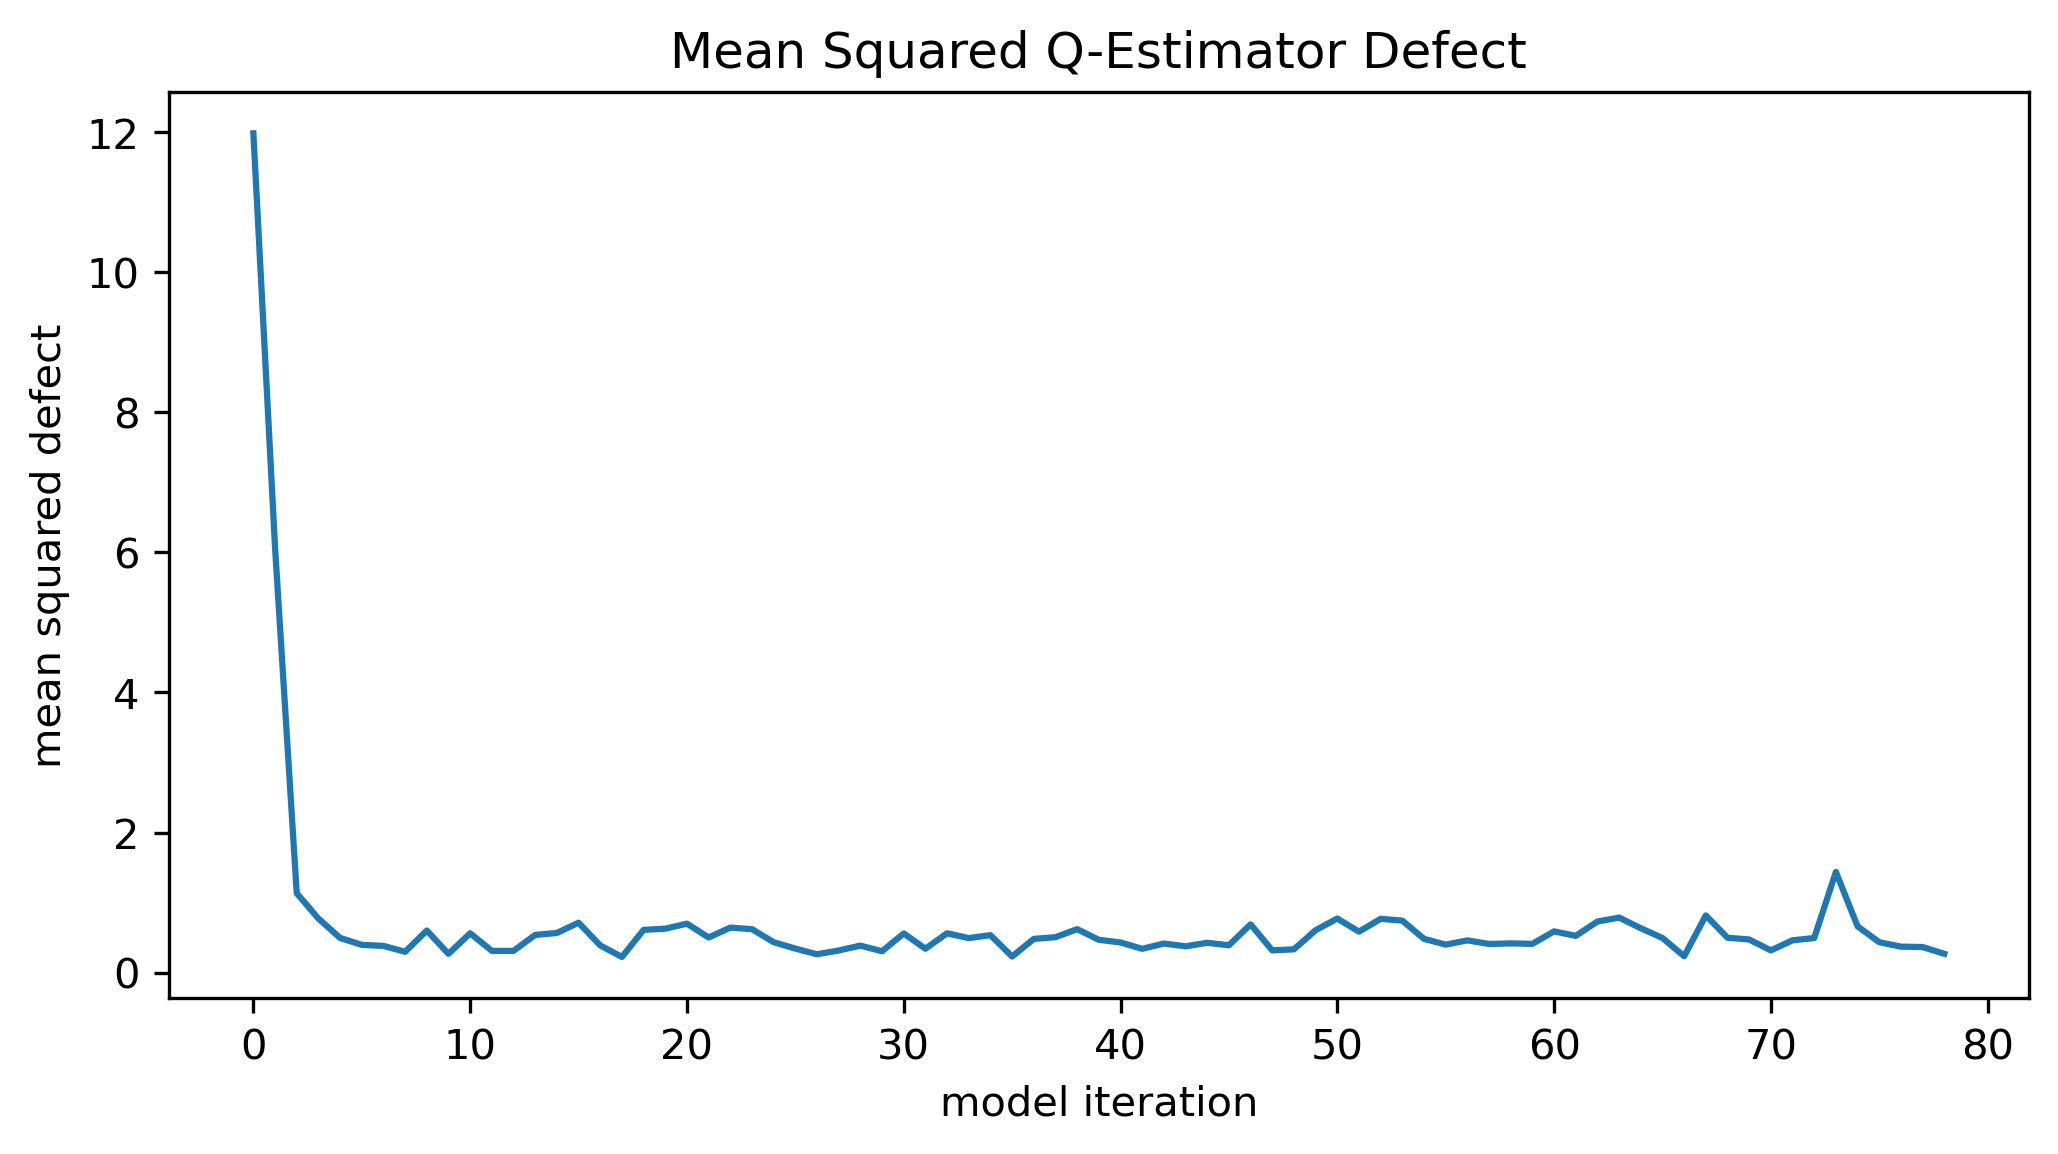

In [294]:
stats = np.loadtxt("./logs/defect.log", delimiter=',')

fig, ax = plt.subplots(figsize=(8,4))

ax.plot(stats[:,0])

ax.set_title("Mean Squared Q-Estimator Defect")
ax.set_xlabel("model iteration")
ax.set_ylabel("mean squared defect")
# ax.set_ylim(0)
# ax.set_yscale('log')

plt.show()

### Agent performance during training

In [77]:
def moving_average(a, n=3):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n-1:] / n

def moving_std(a, n = 3):
    res = np.empty(len(a) - n + 1)
    for i in range(len(a) - n + 1):
        res[i] = np.std(a[i:i + n])
    return res

def plot_with_mov_avg(ax, data, width, label, color):
    ax.plot(data, 'o', label=label, color=color, ms = 3)
    
    indices = np.arange(len(data) - width + 1) + width // 2
    ax.plot(indices, 
        moving_average(data, width), 
        linestyle="dashed", 
        color=color,
        label="moving average (n={})".format(width)
    )

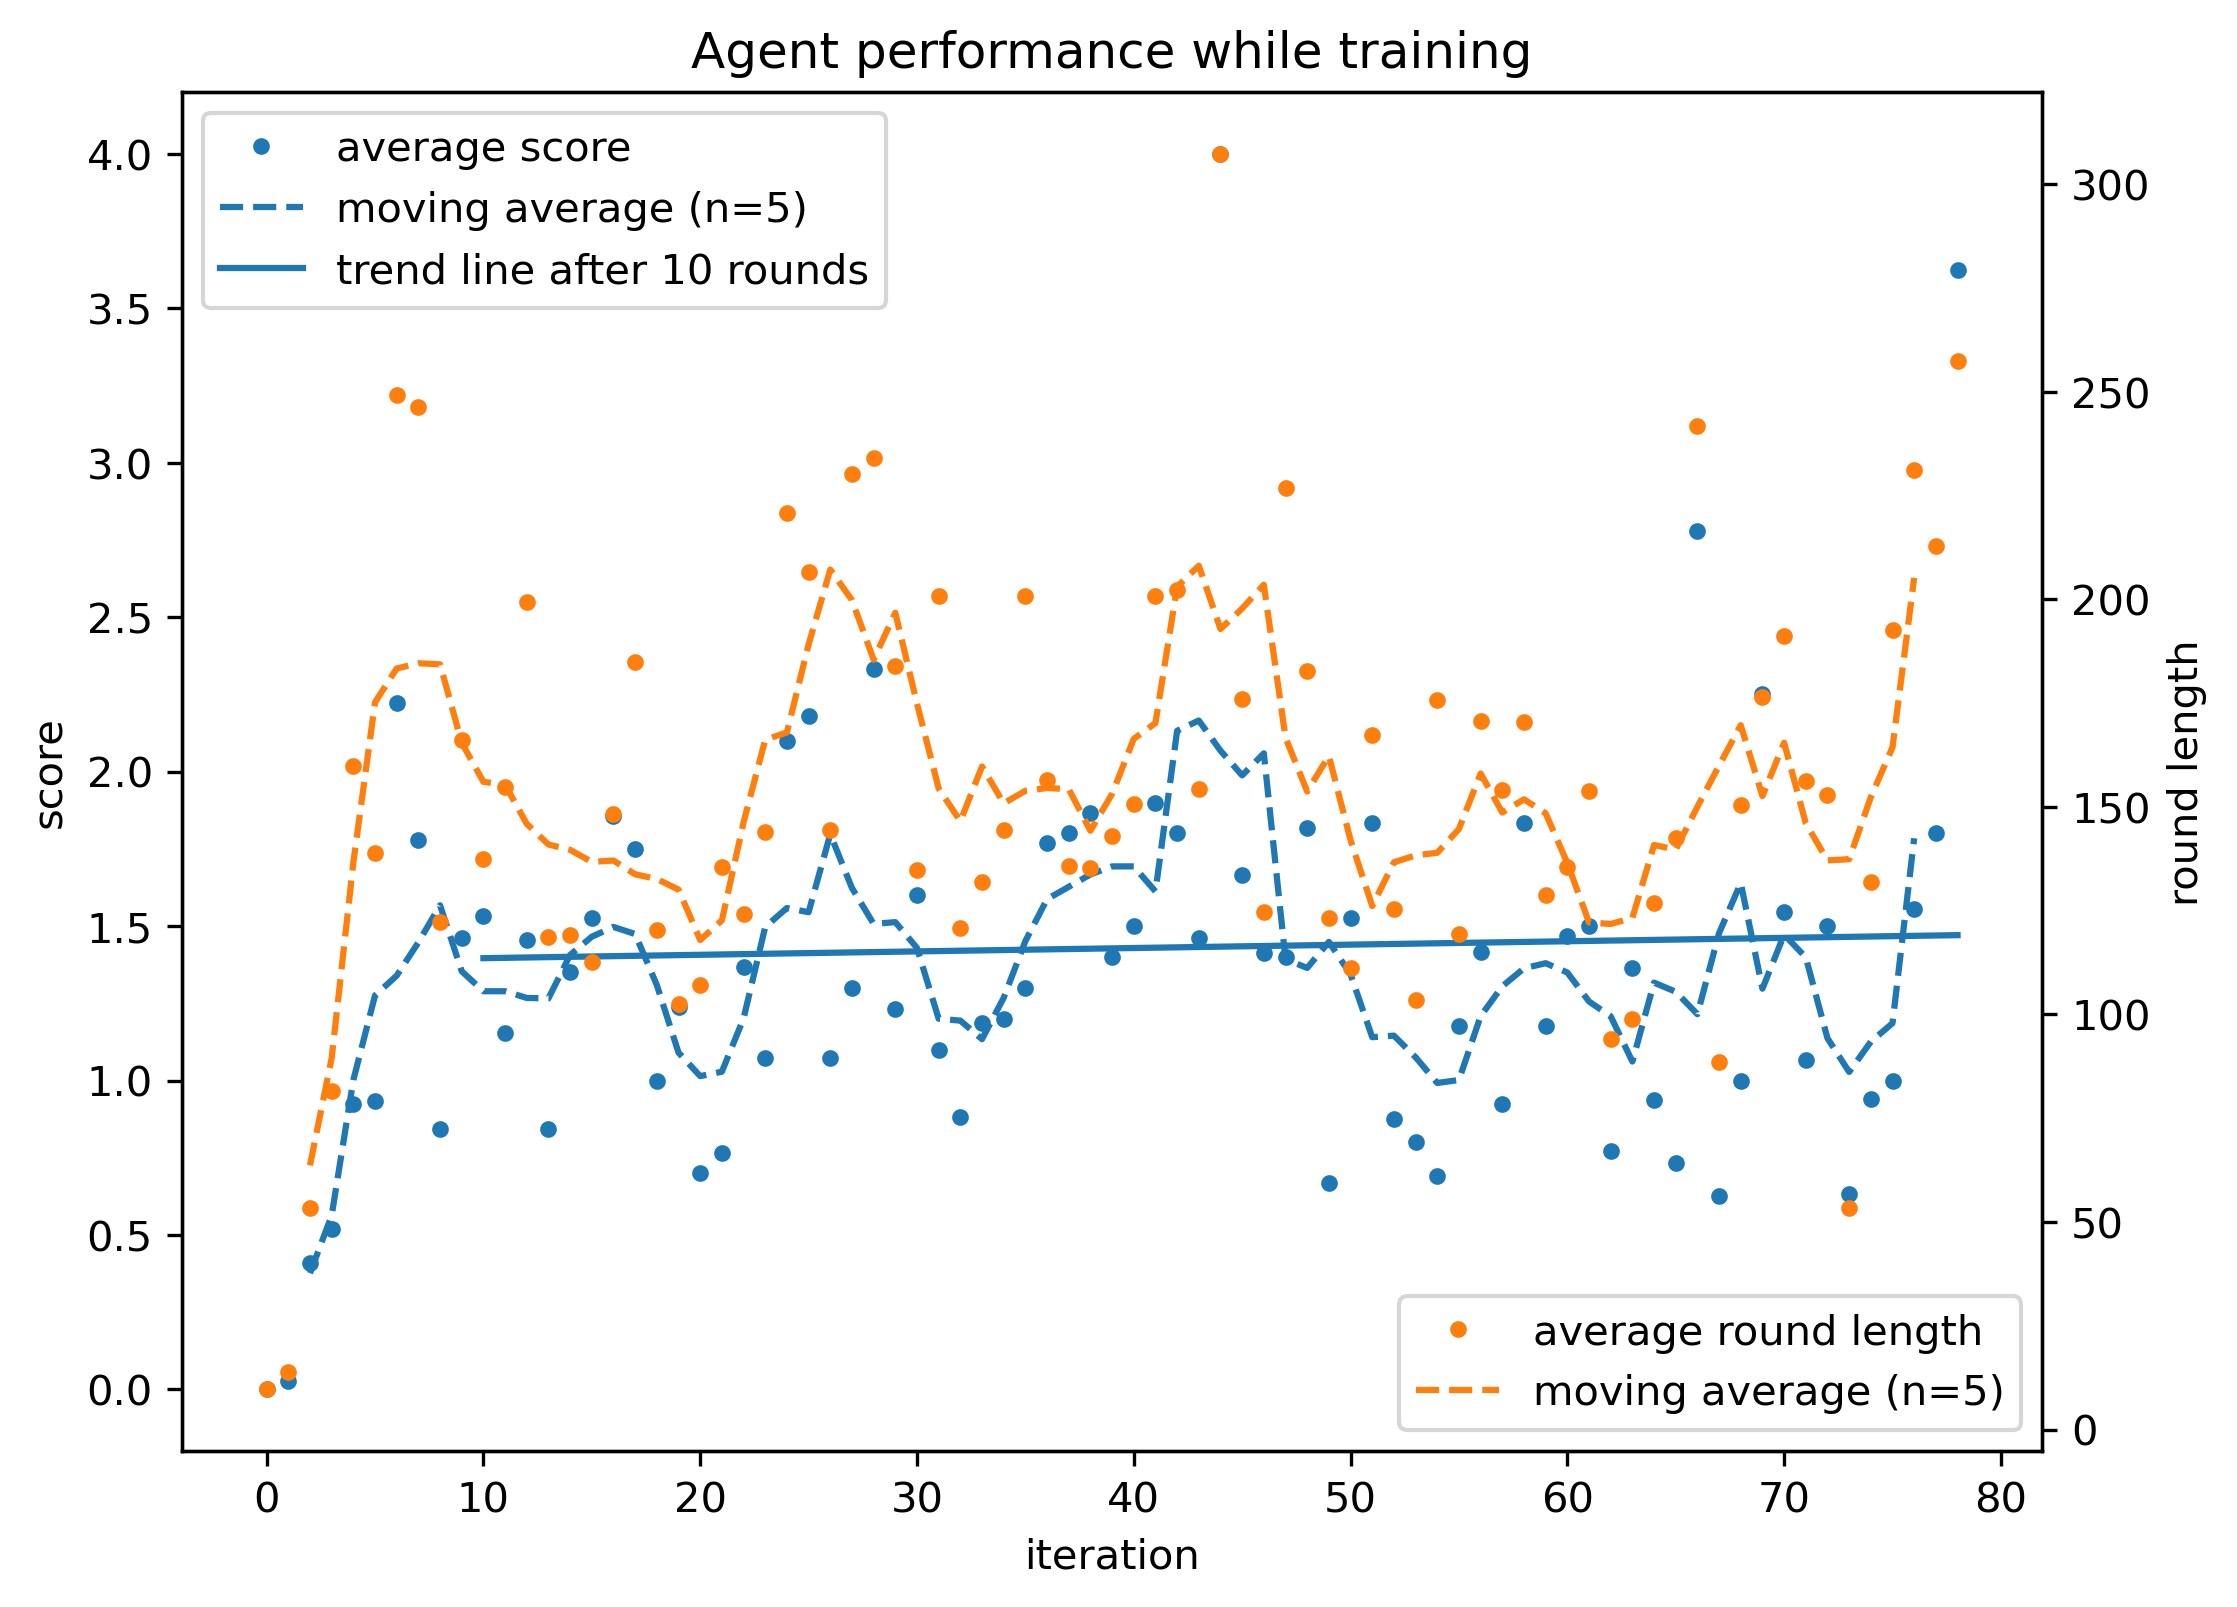

In [290]:
stats = np.loadtxt("./logs/defect.log", delimiter=',')
score = stats[:,1]
round_length = stats[:,2]

width = 5 # moving average width
skip = 10 # number of iterations to skip for trend line

fig, ax = plt.subplots(figsize=(8,6))
N = np.shape(stats)[0]

plot_with_mov_avg(ax, score, width,
    color = plt.get_cmap('tab10')(0),
    label = "average score"
)

if N > skip:
    x = np.arange(skip, N)
    p = np.poly1d(np.polyfit(x, score[skip:], 1))
    ax.plot(x,p(x), label="trend line after {} rounds".format(skip))

ax.set_title("Agent performance while training")
ax.set_ylabel("score")
ax.set_xlabel("iteration")
ax.legend(loc = "upper left")

ax2 = ax.twinx()

plot_with_mov_avg(ax2, round_length, width,
    color = plt.get_cmap('tab10')(1),
    label = "average round length"
)

ax2.set_ylabel("round length")
ax2.legend(loc = "lower right")

plt.show()

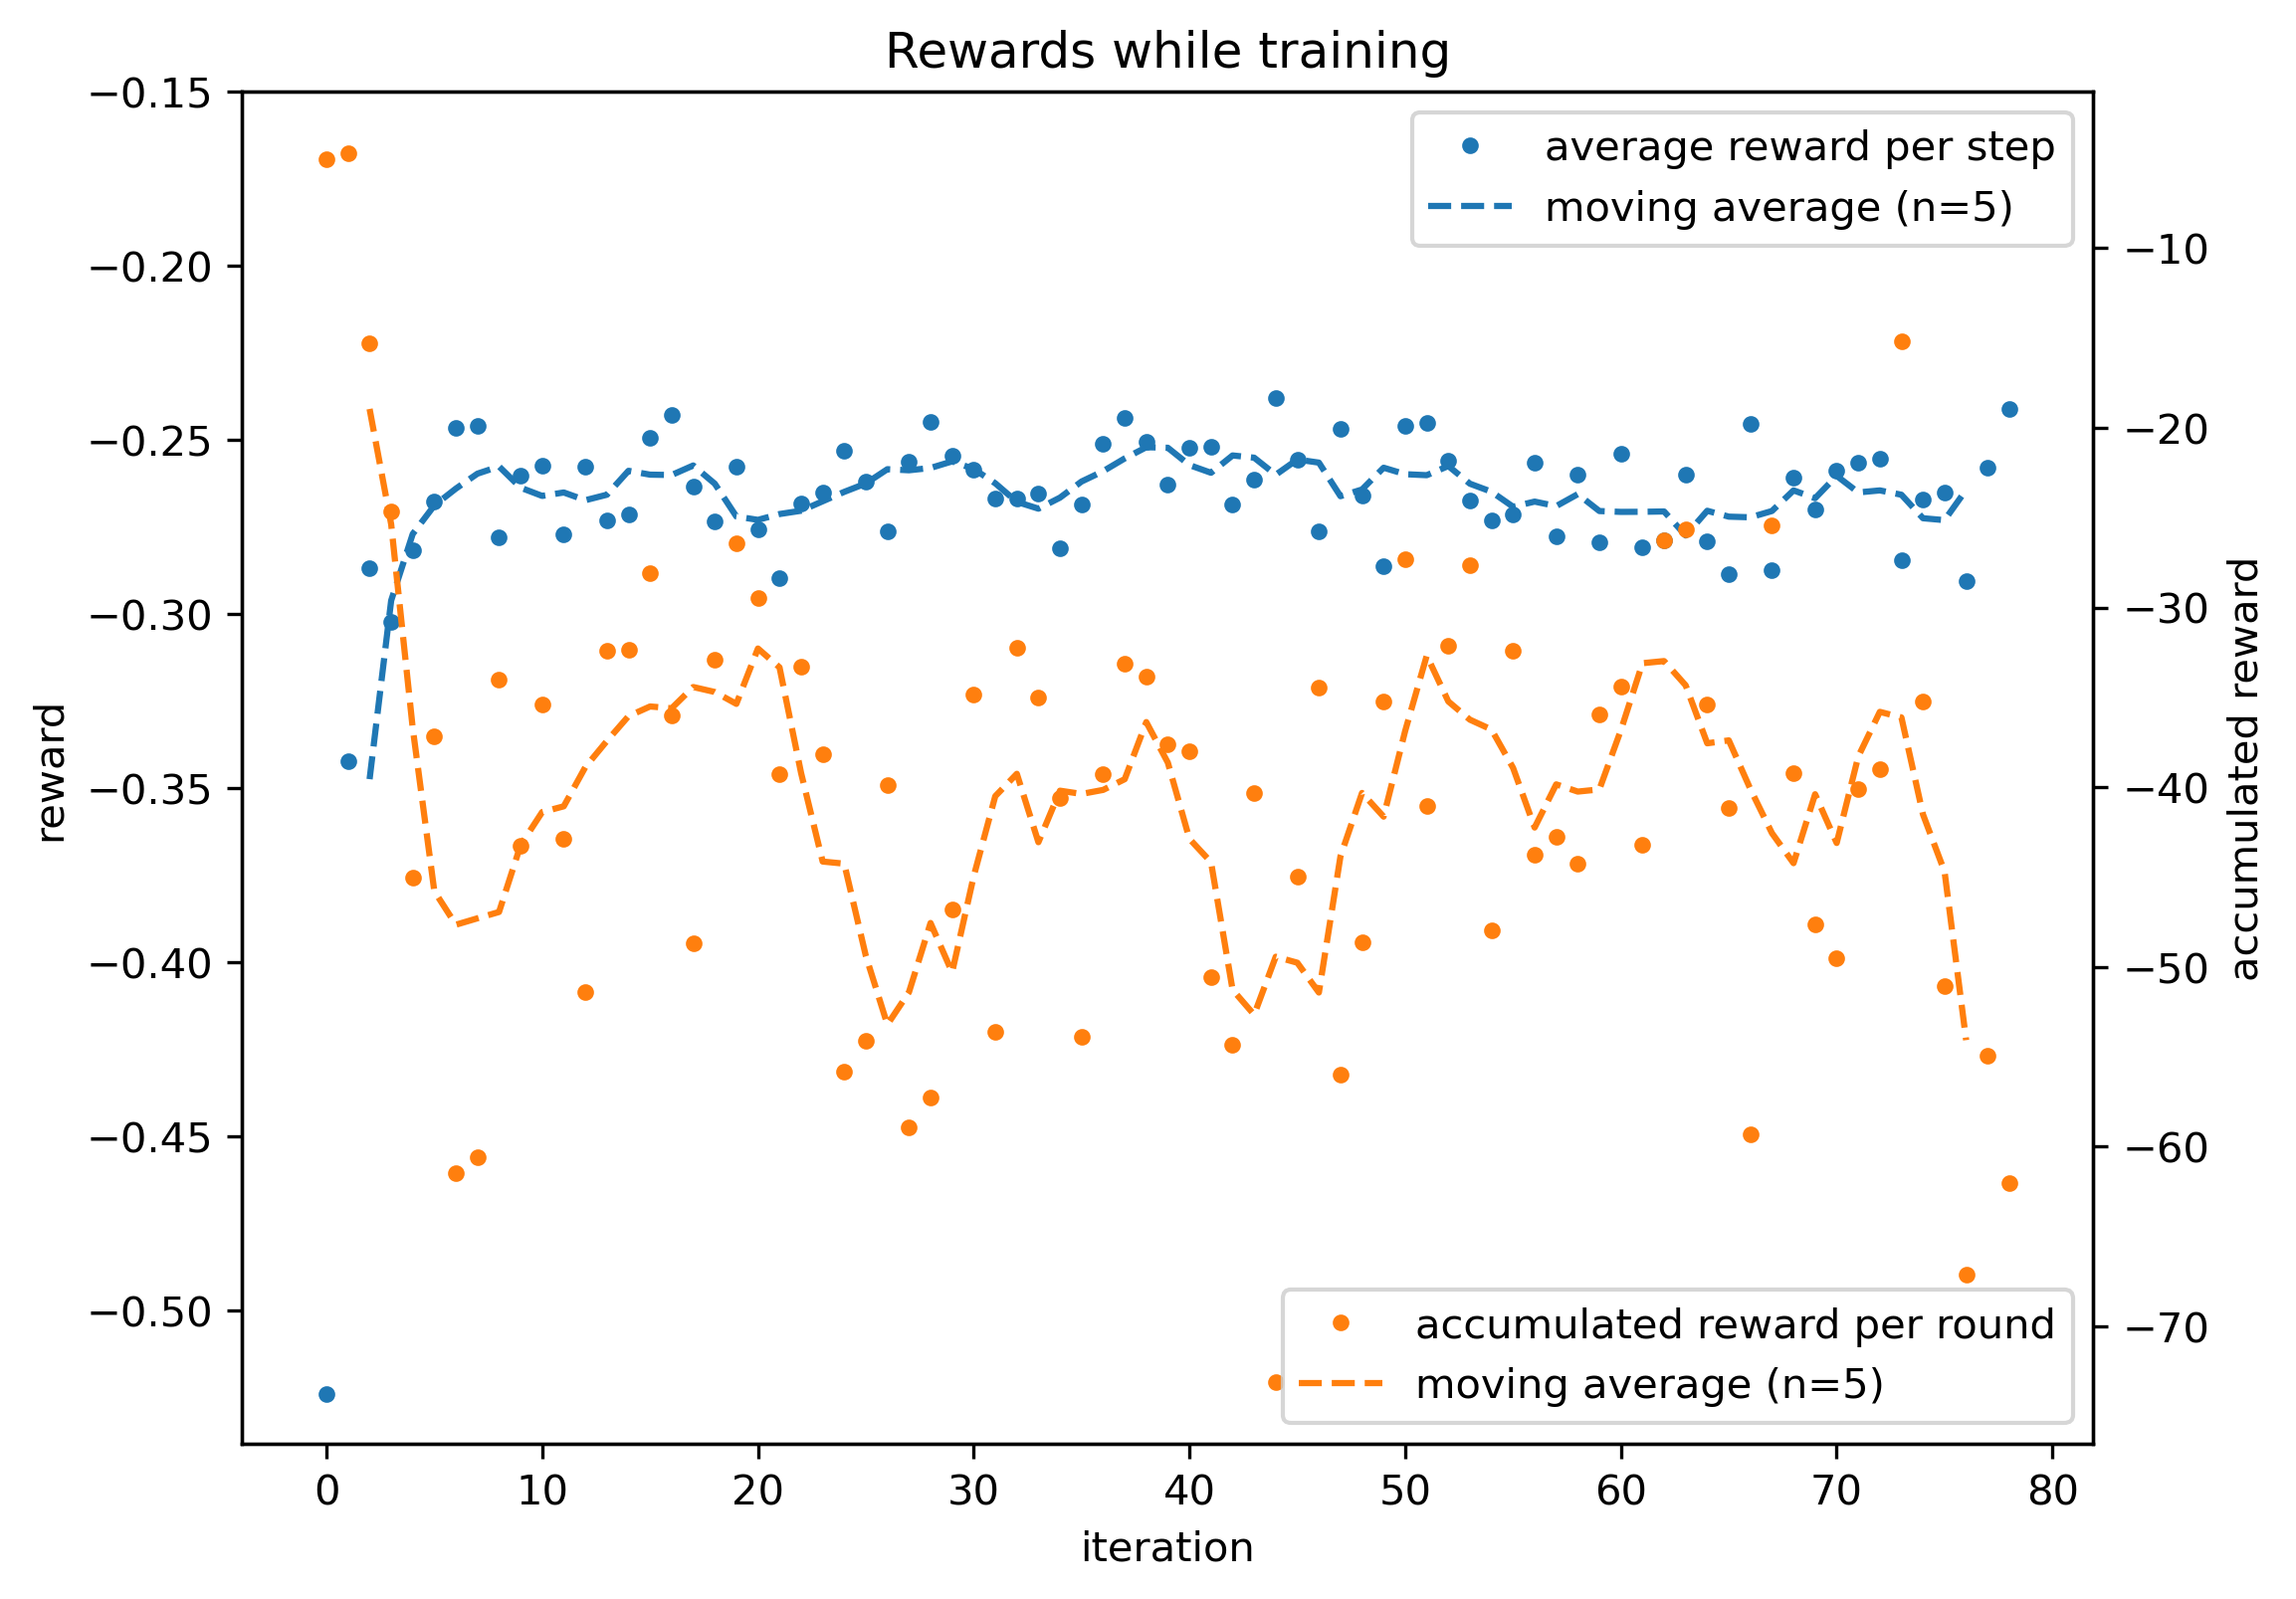

In [293]:
stats = np.loadtxt("./logs/defect.log", delimiter=',')
round_length = stats[:,2]
reward = stats[:,5]

width = 5

fig, ax = plt.subplots(figsize=(8,6))

plot_with_mov_avg(ax, reward, width,
    color = plt.get_cmap('tab10')(0),
    label = "average reward per step"
)
    
ax.set_title("Rewards while training")
ax.set_xlabel("iteration")
ax.set_ylabel("reward")
ax.set_ylim(None, -0.15)
ax.legend(loc = "upper right")

ax2 = ax.twinx()

plot_with_mov_avg(ax2, reward * round_length, width,
    color = plt.get_cmap('tab10')(1),
    label = "accumulated reward per round"
)

ax2.set_ylabel("accumulated reward")
ax2.legend(loc = "lower right")

plt.show()

### Runtime

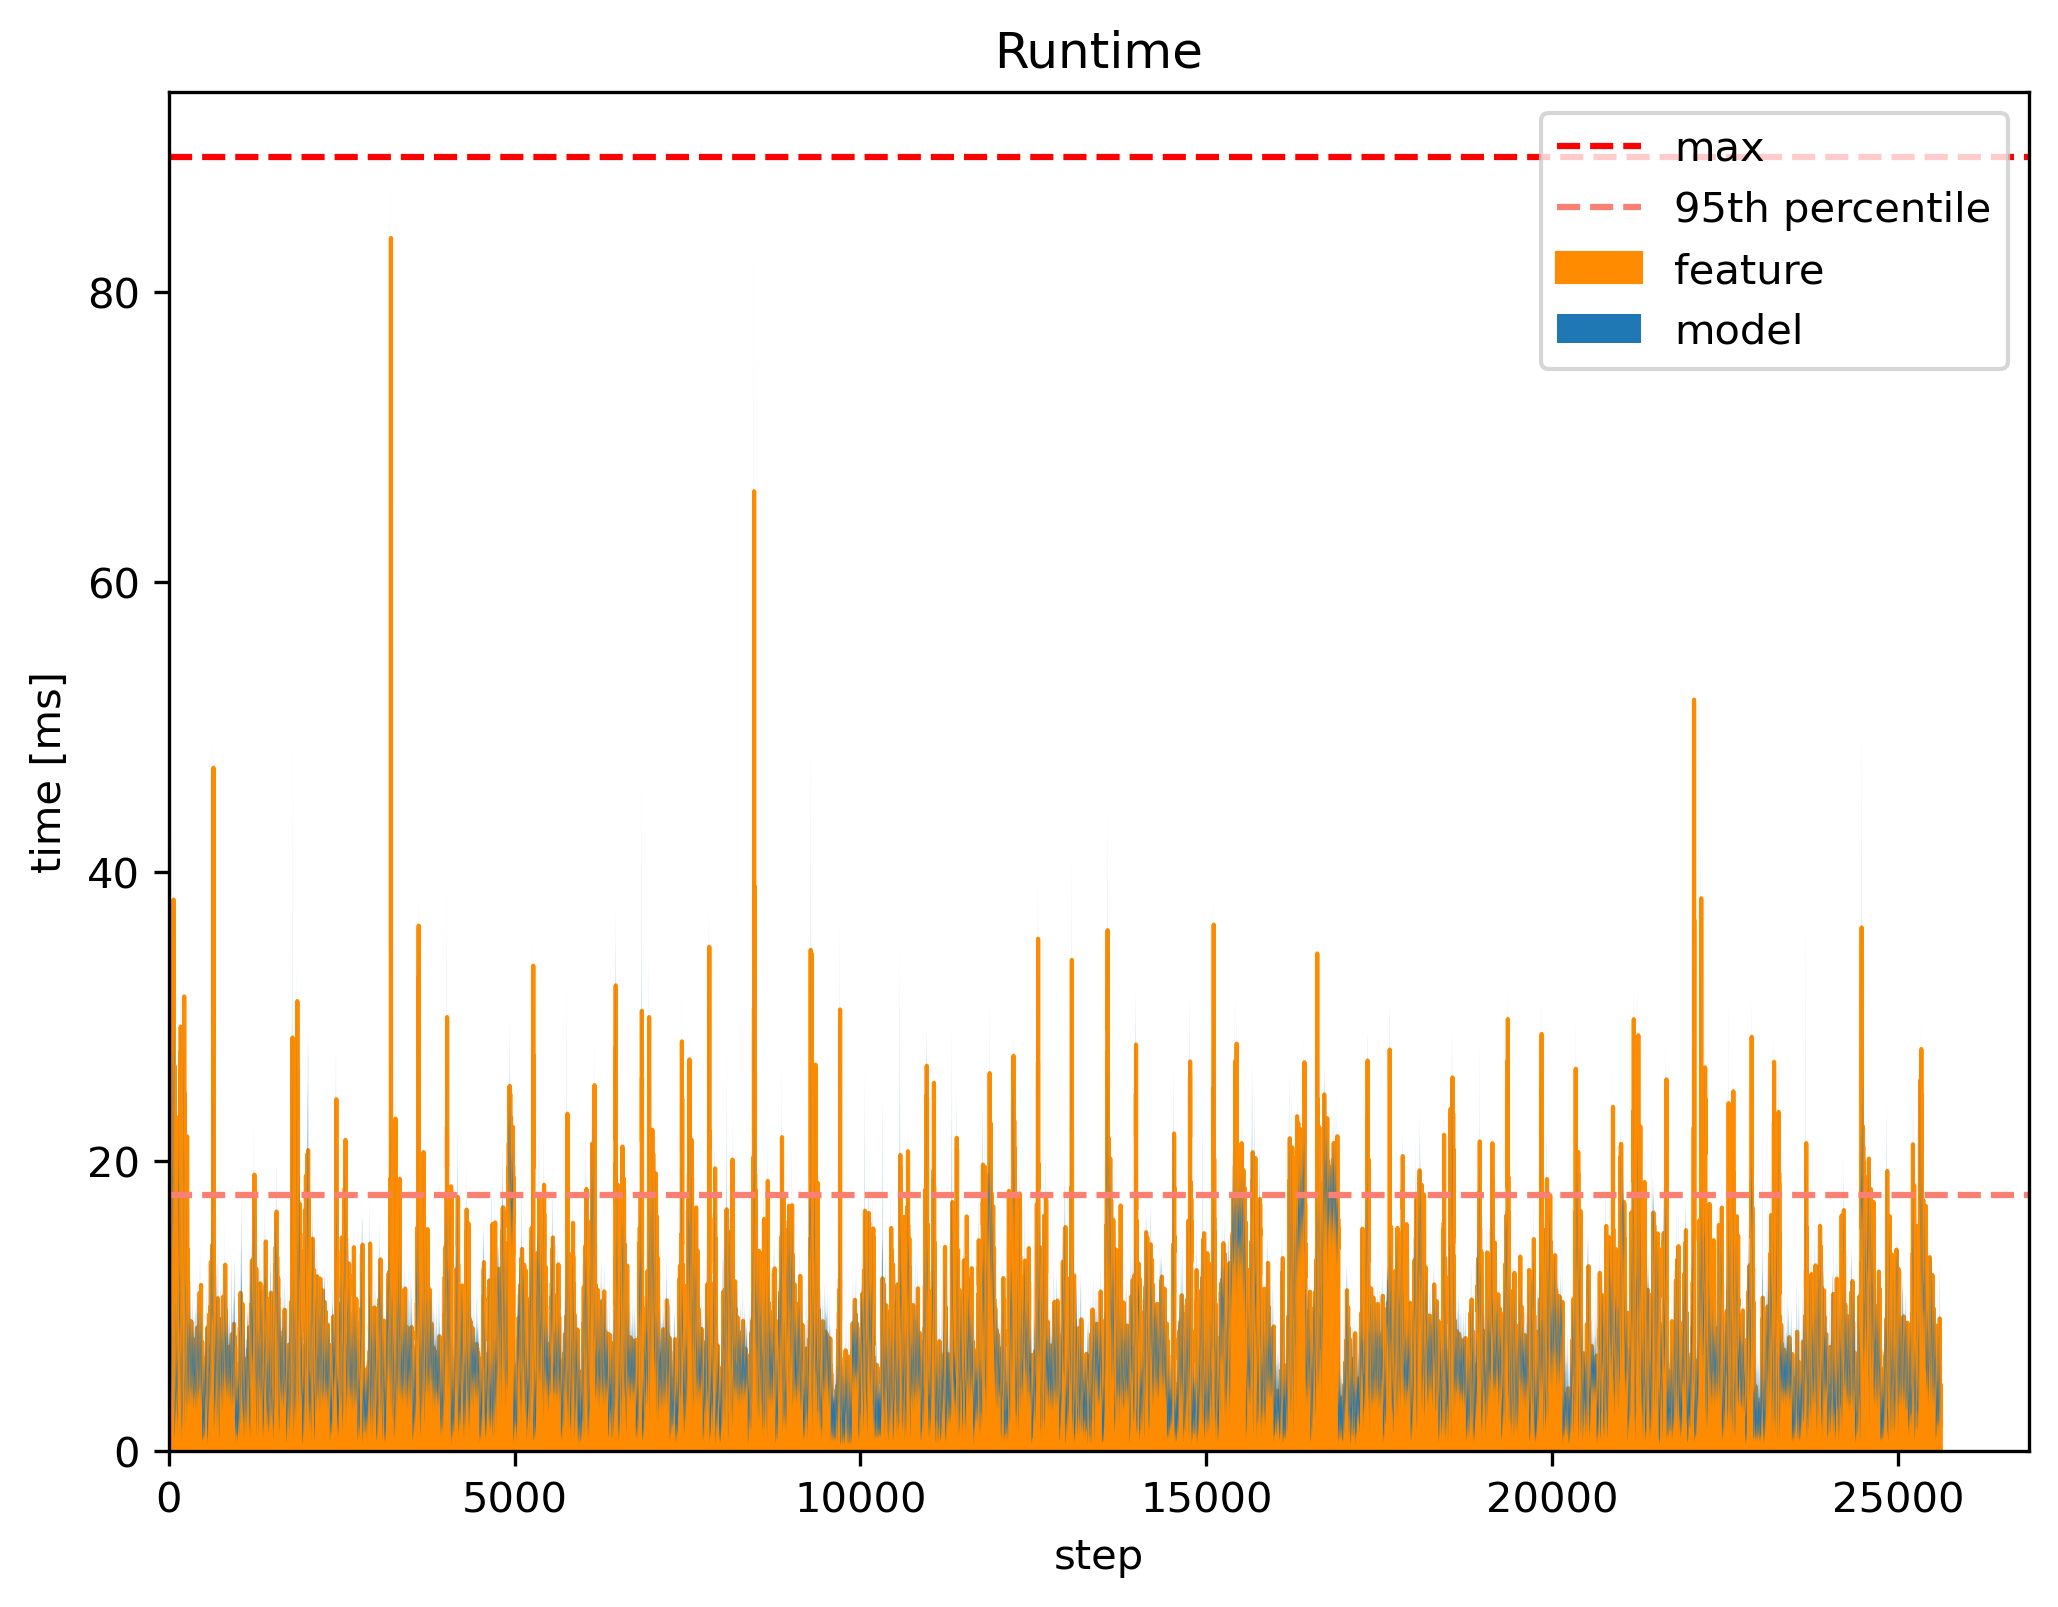

In [55]:
timings = np.loadtxt("./logs/timing.log", delimiter=',')

t_feature = timings[:,0] * 1000
t_complete = timings[:, 1] * 1000

N = len(t_feature)

fig, ax = plt.subplots(figsize=(8, 6))

max_time = np.max(t_complete)
percentile_95 = np.percentile(t_complete, 95)

ax.fill_between(range(N), t_feature, color='darkorange', label="feature")
ax.fill_between(range(N), t_feature , t_complete, label="model")

plt.axhline(y=max_time, color='red', linestyle='--', label='max')
plt.axhline(y=percentile_95, color='salmon', linestyle='--', label='95th percentile')

ax.set_title("Runtime")
ax.set_ylabel("time [ms]")
ax.set_xlabel("step")
ax.legend(loc='upper right')
ax.set_xlim(0)
ax.set_ylim(0)

plt.show()

### Feature Correlation

In [ ]:
features = np.loadtxt("./logs/features.log", delimiter=',')
Q = np.loadtxt("./logs/q.log", delimiter=',')

ACTIONS = ['UP', 'RIGHT', 'DOWN', 'LEFT', 'WAIT', 'BOMB']
FEATURES = ["trav_right", "trav_down", "trav_left", "trav_up", 
    "trav_rd", "trav_ld", "trav_lu", "trav_ru",
    "bomb_available",
    "surv_right", "surv_down", "surv_left", "surv_up", "surv_wait", "surv_bomb",
    "coin_right", "coin_down", "coin_left", "coin_up", 
    "coin_dist",
    "crate_right", "crate_down", "crate_left", "crate_up",
    "crate_dist",
    "crate_potential",
    "player_right", "player_down", "player_left", "player_up", 
    "player_dist"]

features -= np.mean(features, axis = 0)
var_features = np.var(features, axis = 0)

for i in range(len(ACTIONS)):
    Q_action = Q[:, i]

    var_q = np.var(Q_action)

    Q_action = np.reshape(Q_action - np.mean(Q_action), (-1,1))

    cov = np.mean(features * Q_action, axis = 0) / np.sqrt(var_features * var_q)

    fig, ax = plt.subplots(figsize=(8,3))

    ax.bar(FEATURES, cov)
    plt.xticks(rotation='vertical')

    ax.set_title("Feature Correlation coefficients for action " + ACTIONS[i])
    ax.set_xlabel("feature")
    ax.set_ylabel("correlation coefficient")

### Evaluate Score

In [3]:
import json
import os

STATSFILE = "stats.json"
def evaluate_performance(model, rounds, agent="agent_quapsel"):
    if os.path.exists(STATSFILE):
        os.remove(STATSFILE)
    os.system(f"python3 ../../main.py play --my-agent {agent} --no-gui --n-rounds {rounds} --save-stats {STATSFILE} --model {model}")

def plot_performance():
    fig, ax = plt.subplots(figsize=(8,4))
    with open(STATSFILE, 'r') as f:
        stats = json.load(f)
        by_agent = stats["by_agent"]
        from_coins = np.array([by_agent[agent]["coins"] for agent in by_agent.keys()])
        from_kills =  5 * np.array([by_agent[agent]["kills"] for agent in by_agent.keys()])
        agent_score = [by_agent[agent]["score"] for agent in by_agent.keys()]

        rounds = len(stats["by_round"])
        ax.bar(by_agent.keys(), from_coins / rounds, label = "coins")
        ax.bar(by_agent.keys(), from_kills / rounds, 
            bottom = from_coins / rounds,
            label = "kills")
        ax.title.set_text("Agent performance")
        ax.set_ylabel("average score per round")
        ax.legend()

    print(f"Total agent score: {agent_score[0]}, other agents: {agent_score[1:]}")
    print(f"Average score per round: {agent_score[0]/rounds}")
    print(f"Percentage of points achieved: {100*np.round(agent_score[0]/sum(agent_score), 2)}%")

    plt.show()

#### Run evaluation

In [308]:
evaluate_performance(model="model.pt", rounds=100)

100%|██████████| 100/100 [08:52<00:00,  5.32s/it]


#### Plot data

Total agent score: 355, other agents: [317, 300, 294]
Average score per round: 3.55
Percentage of points achieved: 28.000000000000004%


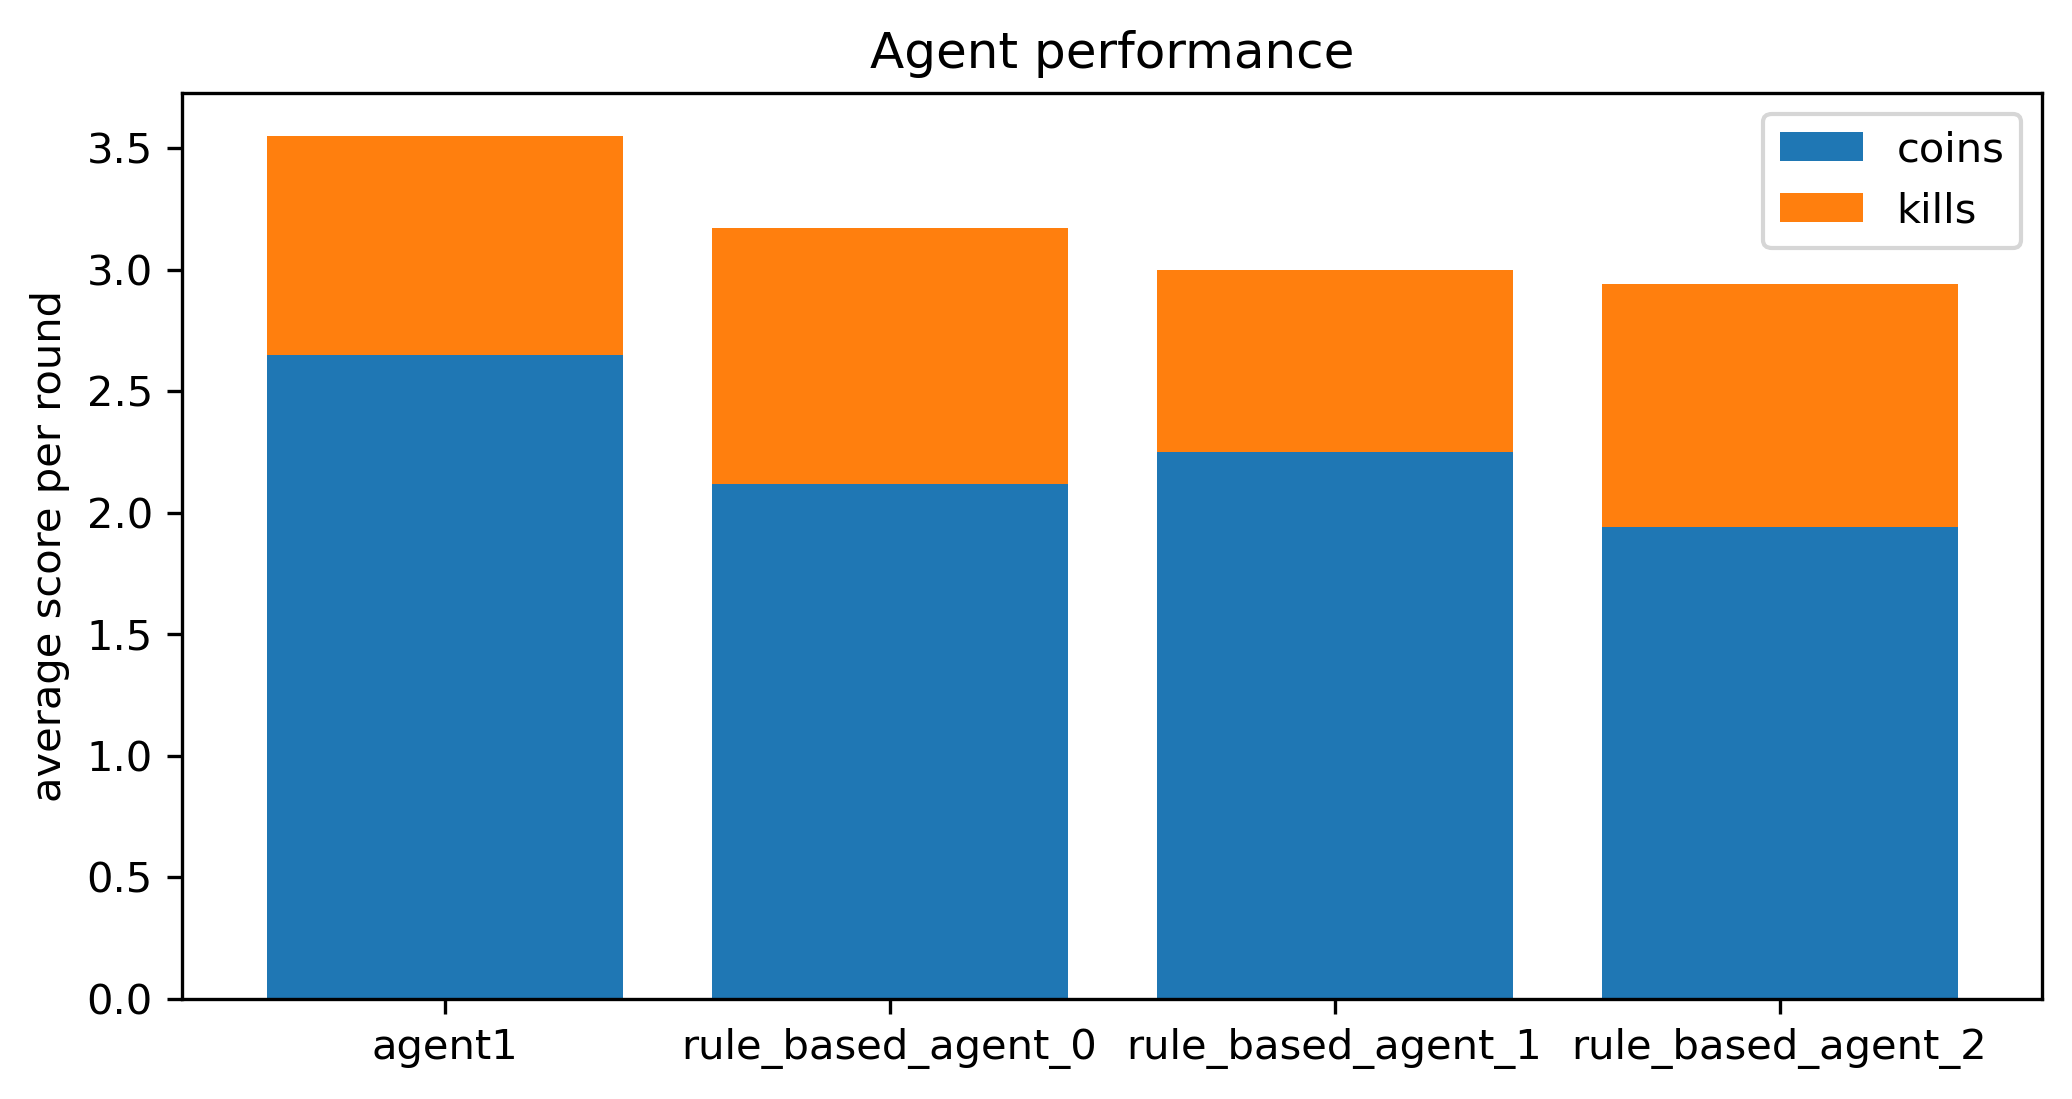

In [309]:
plot_performance()

### Determine best model for submission

100%|██████████| 50/50 [02:46<00:00,  3.32s/it]


Max avg score for model-20.pt: 3.6


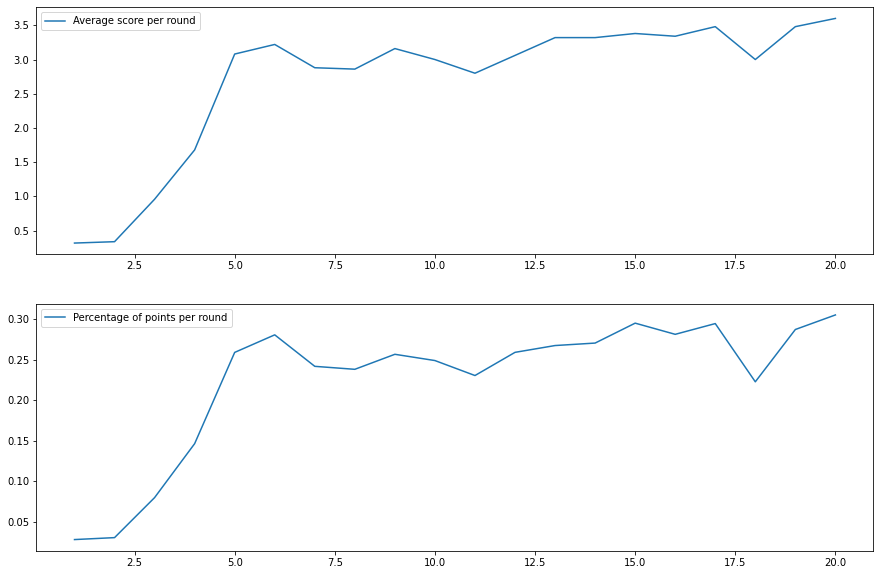

In [14]:
import os
import numpy as np
import matplotlib.pyplot as plt
import json

STATSFILE = "stats.json"
TEST_ROUNDS = 50
AGENT = "agent_quapsel"

avg_score_arr = []
percentage_of_points_arr = []

for i in range(20):
    if os.path.exists(STATSFILE):
        os.remove(STATSFILE)
    model = f"models/model-{i}.pt"
    os.system(f"python3 ../../main.py play --my-agent {AGENT} --no-gui --n-rounds {TEST_ROUNDS} --save-stats {STATSFILE} --model {model}")

    with open(STATSFILE, 'r') as f:
        stats = json.load(f)
        by_agent = stats["by_agent"]
        agent_score = [by_agent[agent]["score"] for agent in by_agent.keys()]
        avg_score_arr.append(agent_score[0]/TEST_ROUNDS)
        percentage_of_points_arr.append(agent_score[0]/sum(agent_score))


max_score = max(avg_score_arr)
max_model = avg_score_arr.index(max_score)
print(f"Max avg score for model-{max_model}.pt: {max_score}")

fig, ax = plt.subplots(2,1, figsize=(15,10))
ax[0].plot(models, avg_score_arr, label="Average score per round")
ax[0].legend()

ax[1].plot(models, percentage_of_points_arr, label="Percentage of points per round")
ax[1].legend()

plt.show()

#### Run 5000 training rounds

In [50]:
os.system("python3 ../../main.py play --my-agent agent_quapsel --train 1 --no-gui --n-rounds 5000")

100%|██████████| 5000/5000 [2:19:12<00:00,  1.67s/it]  


0

#### Run 50 test rounds for each saved model 

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import json

STATSFILE = "stats.json"
TEST_ROUNDS = 50
AGENT = "agent_quapsel"

avg_score_arr = []
percentage_of_points_arr = []

num_of_models = len(os.listdir("models"))

for i in range(num_of_models):
    if os.path.exists(STATSFILE):
        os.remove(STATSFILE)
    model = f"models/model-{i}.pt"
    os.system(f"python3 ../../main.py play --my-agent {AGENT} --no-gui --n-rounds {TEST_ROUNDS} --save-stats {STATSFILE} --model {model}")

    with open(STATSFILE, 'r') as f:
        stats = json.load(f)
        by_agent = stats["by_agent"]
        agent_score = [by_agent[agent]["score"] for agent in by_agent.keys()]
        avg_score_arr.append(agent_score[0]/TEST_ROUNDS)

    if i != 0 and i % 10 == 0:
        print(f"Intermediate result for {i} rounds")
        max_score = max(avg_score_arr)
        max_model = avg_score_arr.index(max_score)
        print(f"Max avg score for model-{max_model}.pt: {max_score}")
        ranked_models = [f"model-{i}.pt" for i in np.argsort(np.array(avg_score_arr))[::-1]]
        print(f"Best models descending: {ranked_models[:8]}")

#### Plot average score of each model

Max avg score for model-76.pt: 4.96
Best models descending: ['model-76.pt', 'model-120.pt', 'model-63.pt', 'model-80.pt', 'model-54.pt', 'model-53.pt', 'model-67.pt', 'model-30.pt', 'model-111.pt', 'model-41.pt', 'model-115.pt', 'model-58.pt', 'model-59.pt', 'model-81.pt', 'model-62.pt', 'model-159.pt', 'model-89.pt', 'model-49.pt', 'model-33.pt', 'model-104.pt', 'model-57.pt', 'model-108.pt', 'model-51.pt', 'model-75.pt', 'model-85.pt', 'model-156.pt', 'model-44.pt', 'model-122.pt', 'model-142.pt', 'model-107.pt', 'model-116.pt', 'model-102.pt', 'model-88.pt', 'model-150.pt', 'model-160.pt', 'model-93.pt', 'model-128.pt', 'model-16.pt', 'model-124.pt', 'model-9.pt', 'model-79.pt', 'model-158.pt', 'model-121.pt', 'model-52.pt', 'model-65.pt', 'model-18.pt', 'model-101.pt', 'model-42.pt', 'model-48.pt', 'model-28.pt', 'model-106.pt', 'model-163.pt', 'model-154.pt', 'model-132.pt', 'model-125.pt', 'model-77.pt', 'model-68.pt', 'model-46.pt', 'model-118.pt', 'model-73.pt', 'model-153.pt',

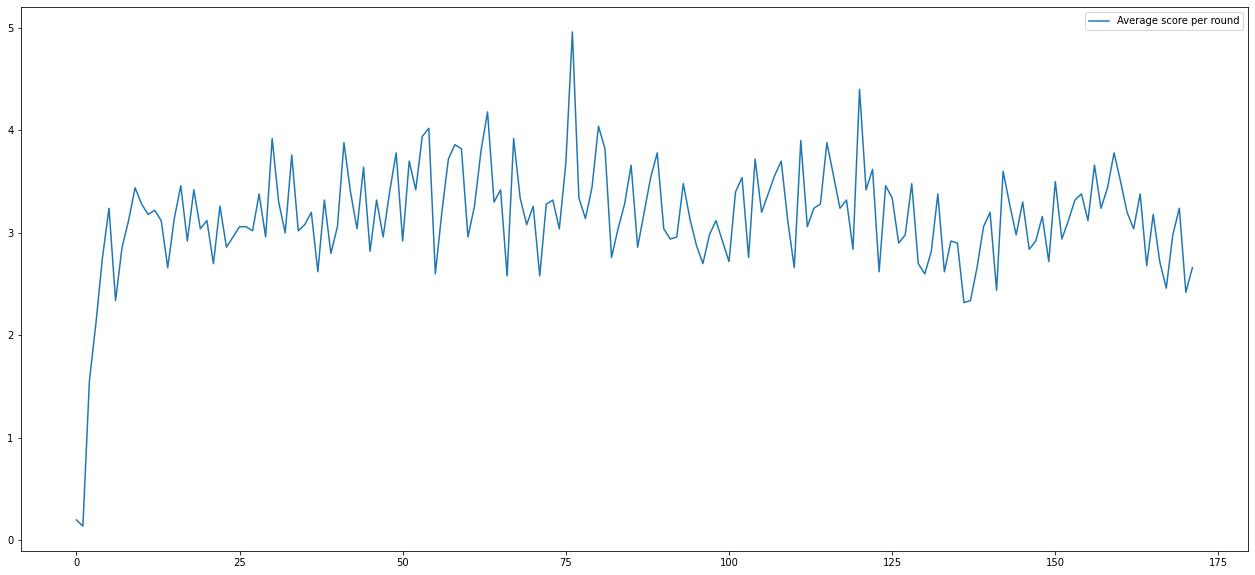

In [52]:
max_score = max(avg_score_arr)
max_model = avg_score_arr.index(max_score)
print(f"Max avg score for model-{max_model}.pt: {max_score}")
ranked_models = [f"model-{i}.pt" for i in np.argsort(np.array(avg_score_arr))[::-1]]
print(f"Best models descending: {ranked_models}")

fig, ax = plt.subplots(1,1, figsize=(22,10))
ax.plot(avg_score_arr, label="Average score per round")
ax.legend()

plt.show()

#### Evaluate more precise with 100 test rounds for best models

100%|██████████| 100/100 [05:06<00:00,  3.06s/it]


Total agent score: 382, other agents: [287, 275, 309]
Average score per round: 3.82
Percentage of points achieved: 30.0%


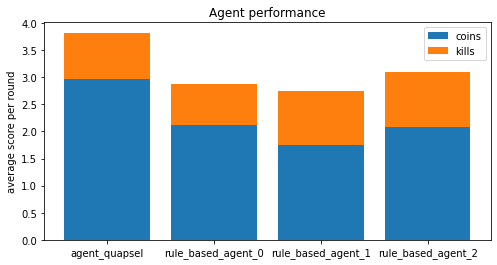

100%|██████████| 100/100 [05:24<00:00,  3.25s/it]


Total agent score: 349, other agents: [320, 311, 320]
Average score per round: 3.49
Percentage of points achieved: 27.0%


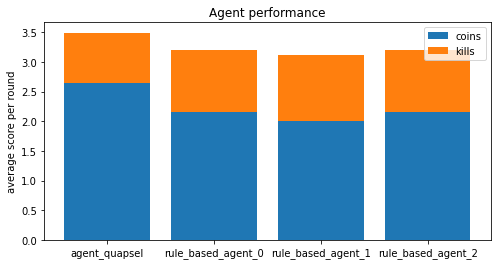

100%|██████████| 100/100 [05:37<00:00,  3.37s/it]


Total agent score: 357, other agents: [254, 296, 292]
Average score per round: 3.57
Percentage of points achieved: 30.0%


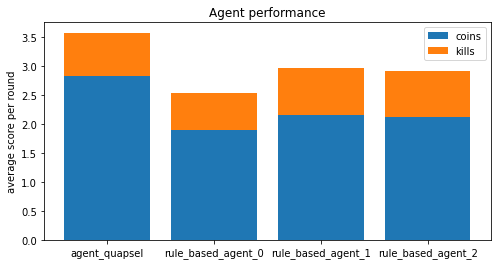

100%|██████████| 100/100 [05:20<00:00,  3.21s/it]


Total agent score: 357, other agents: [293, 304, 275]
Average score per round: 3.57
Percentage of points achieved: 28.999999999999996%


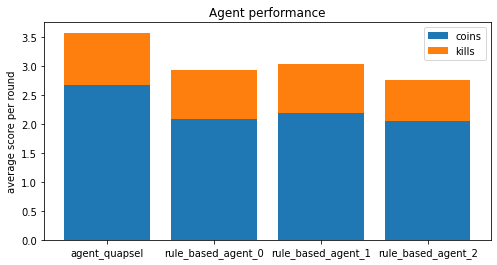

100%|██████████| 100/100 [04:53<00:00,  2.93s/it]


Total agent score: 433, other agents: [321, 293, 245]
Average score per round: 4.33
Percentage of points achieved: 34.0%


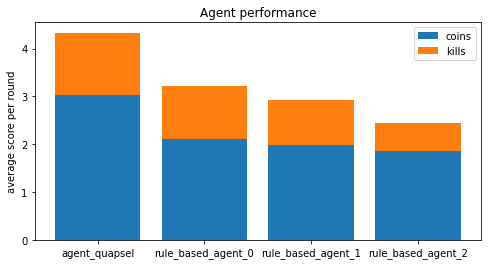

100%|██████████| 100/100 [04:44<00:00,  2.84s/it]


Total agent score: 370, other agents: [284, 294, 287]
Average score per round: 3.7
Percentage of points achieved: 30.0%


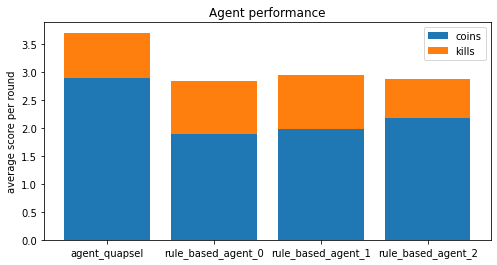

100%|██████████| 100/100 [05:26<00:00,  3.26s/it]


Total agent score: 343, other agents: [344, 327, 263]
Average score per round: 3.43
Percentage of points achieved: 27.0%


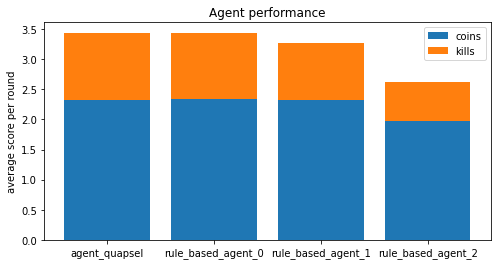

100%|██████████| 100/100 [04:57<00:00,  2.97s/it]


Total agent score: 336, other agents: [294, 300, 292]
Average score per round: 3.36
Percentage of points achieved: 27.0%


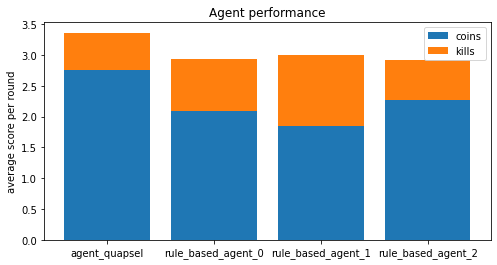

100%|██████████| 100/100 [05:05<00:00,  3.05s/it]


Total agent score: 298, other agents: [285, 378, 295]
Average score per round: 2.98
Percentage of points achieved: 24.0%


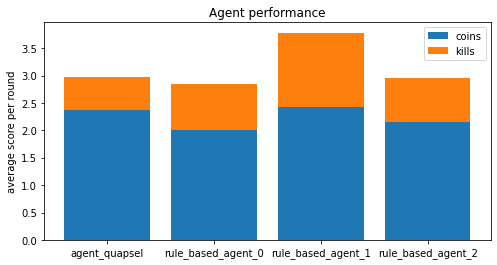

100%|██████████| 100/100 [05:23<00:00,  3.23s/it]


Total agent score: 308, other agents: [292, 314, 333]
Average score per round: 3.08
Percentage of points achieved: 25.0%


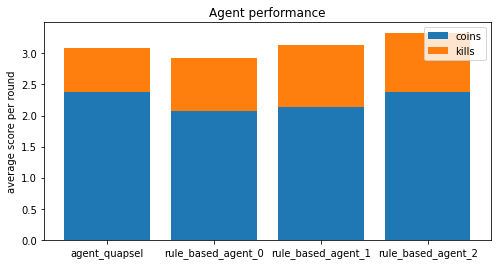

100%|██████████| 100/100 [06:05<00:00,  3.66s/it]


Total agent score: 340, other agents: [268, 290, 277]
Average score per round: 3.4
Percentage of points achieved: 28.999999999999996%


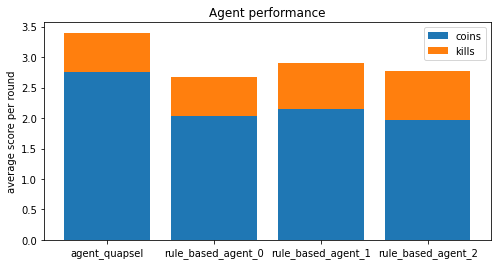

100%|██████████| 100/100 [04:53<00:00,  2.94s/it]


Total agent score: 346, other agents: [286, 283, 333]
Average score per round: 3.46
Percentage of points achieved: 28.000000000000004%


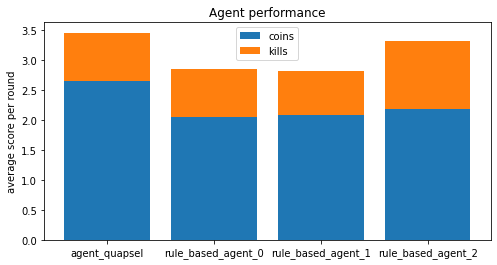

In [54]:
TEST_ROUNDS = 100
models = ['model-76.pt', 'model-120.pt', 'model-63.pt', 'model-80.pt', 'model-54.pt', 'model-53.pt', 'model-67.pt', 'model-30.pt', 'model-111.pt', 'model-41.pt', 'model-115.pt', 'model-58.pt']
for model in models:
    evaluate_performance(model=f"models/{model}", rounds=TEST_ROUNDS)
    plot_performance()

#### Compare best three agents with 500 test rounds

# =============== model-76.pt =============== #


100%|██████████| 500/500 [40:15<00:00,  4.83s/it]


Total agent score: 1793, other agents: [1467, 1516, 1463]
Average score per round: 3.586
Percentage of points achieved: 28.999999999999996%


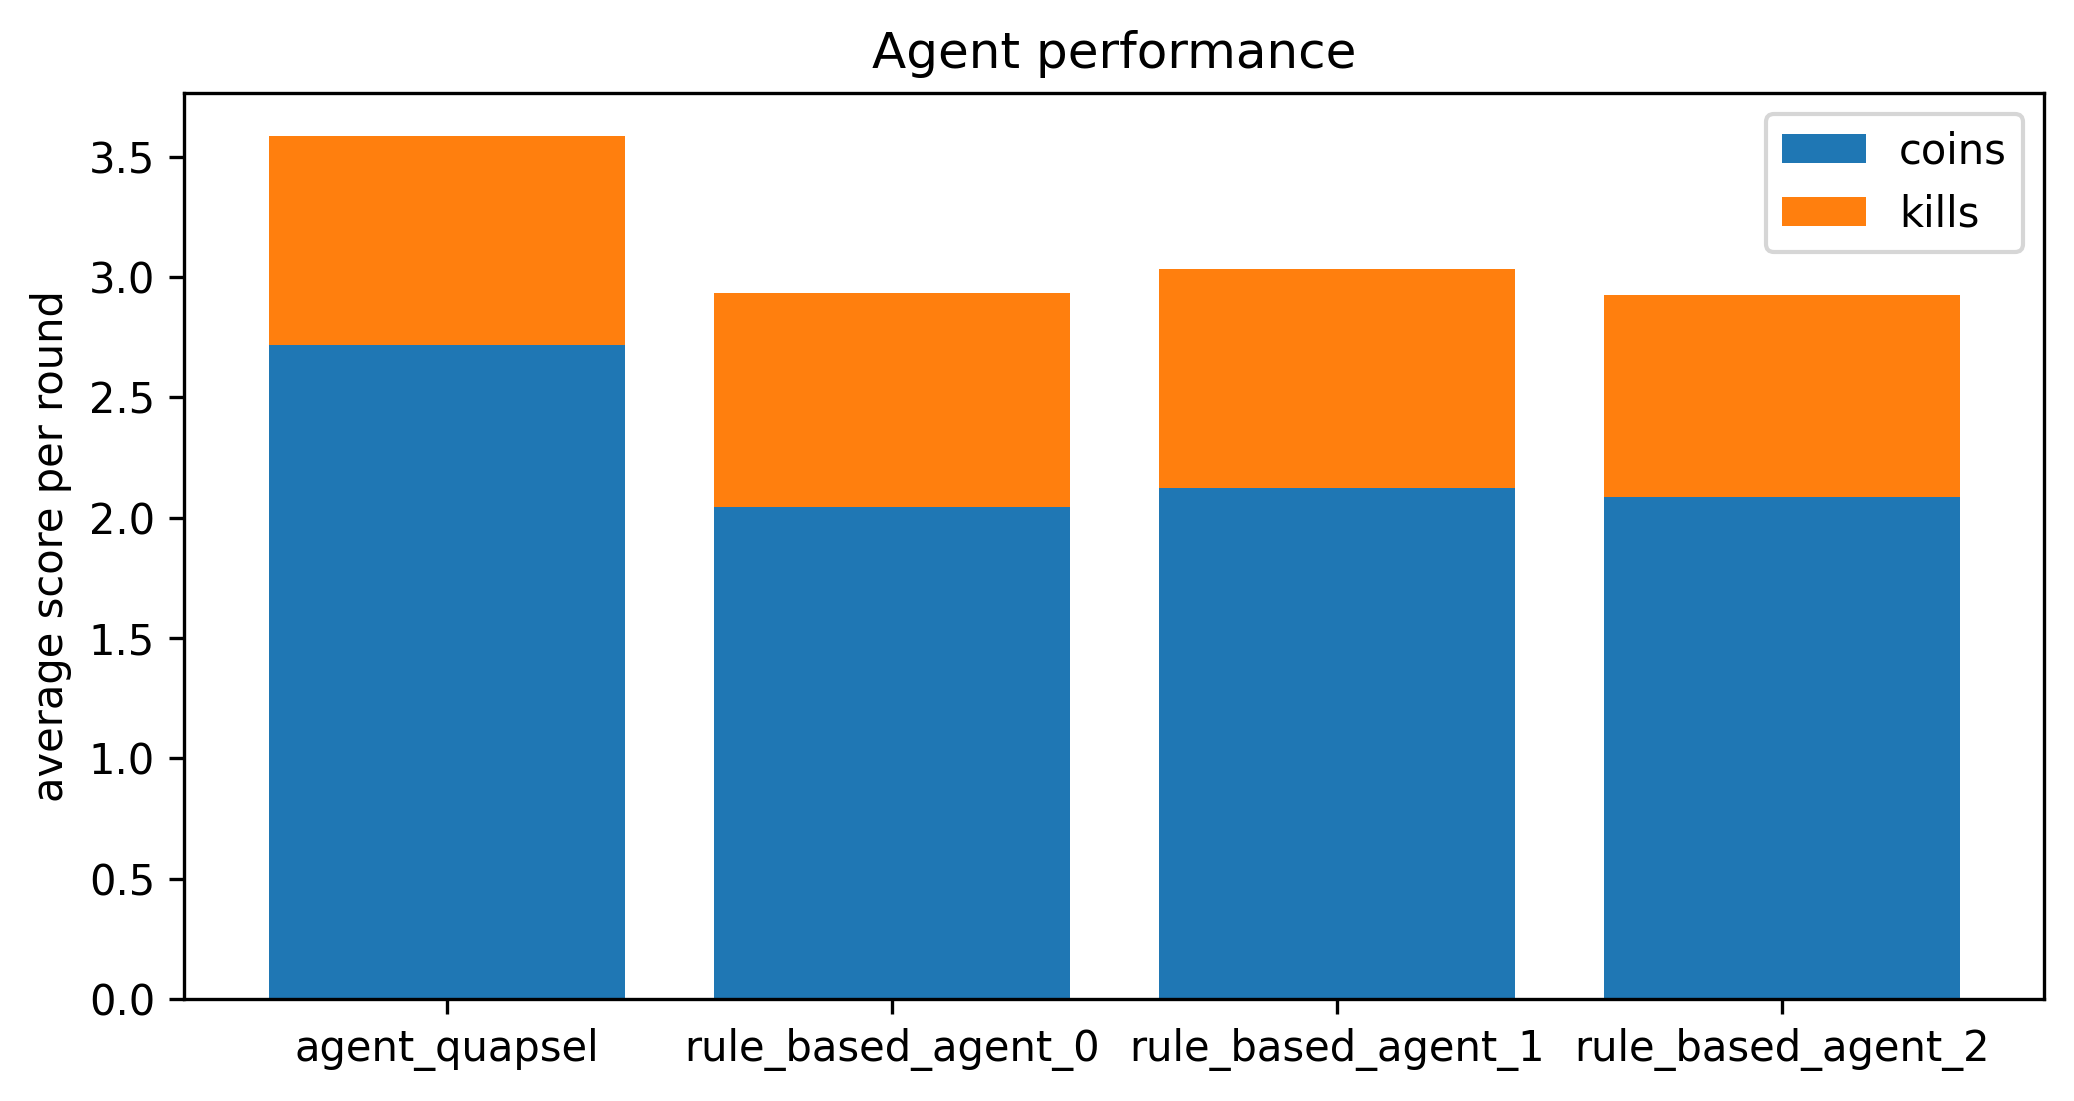

# =============== model-54.pt =============== #


100%|██████████| 500/500 [32:12<00:00,  3.87s/it]


Total agent score: 1805, other agents: [1524, 1529, 1464]
Average score per round: 3.61
Percentage of points achieved: 28.999999999999996%


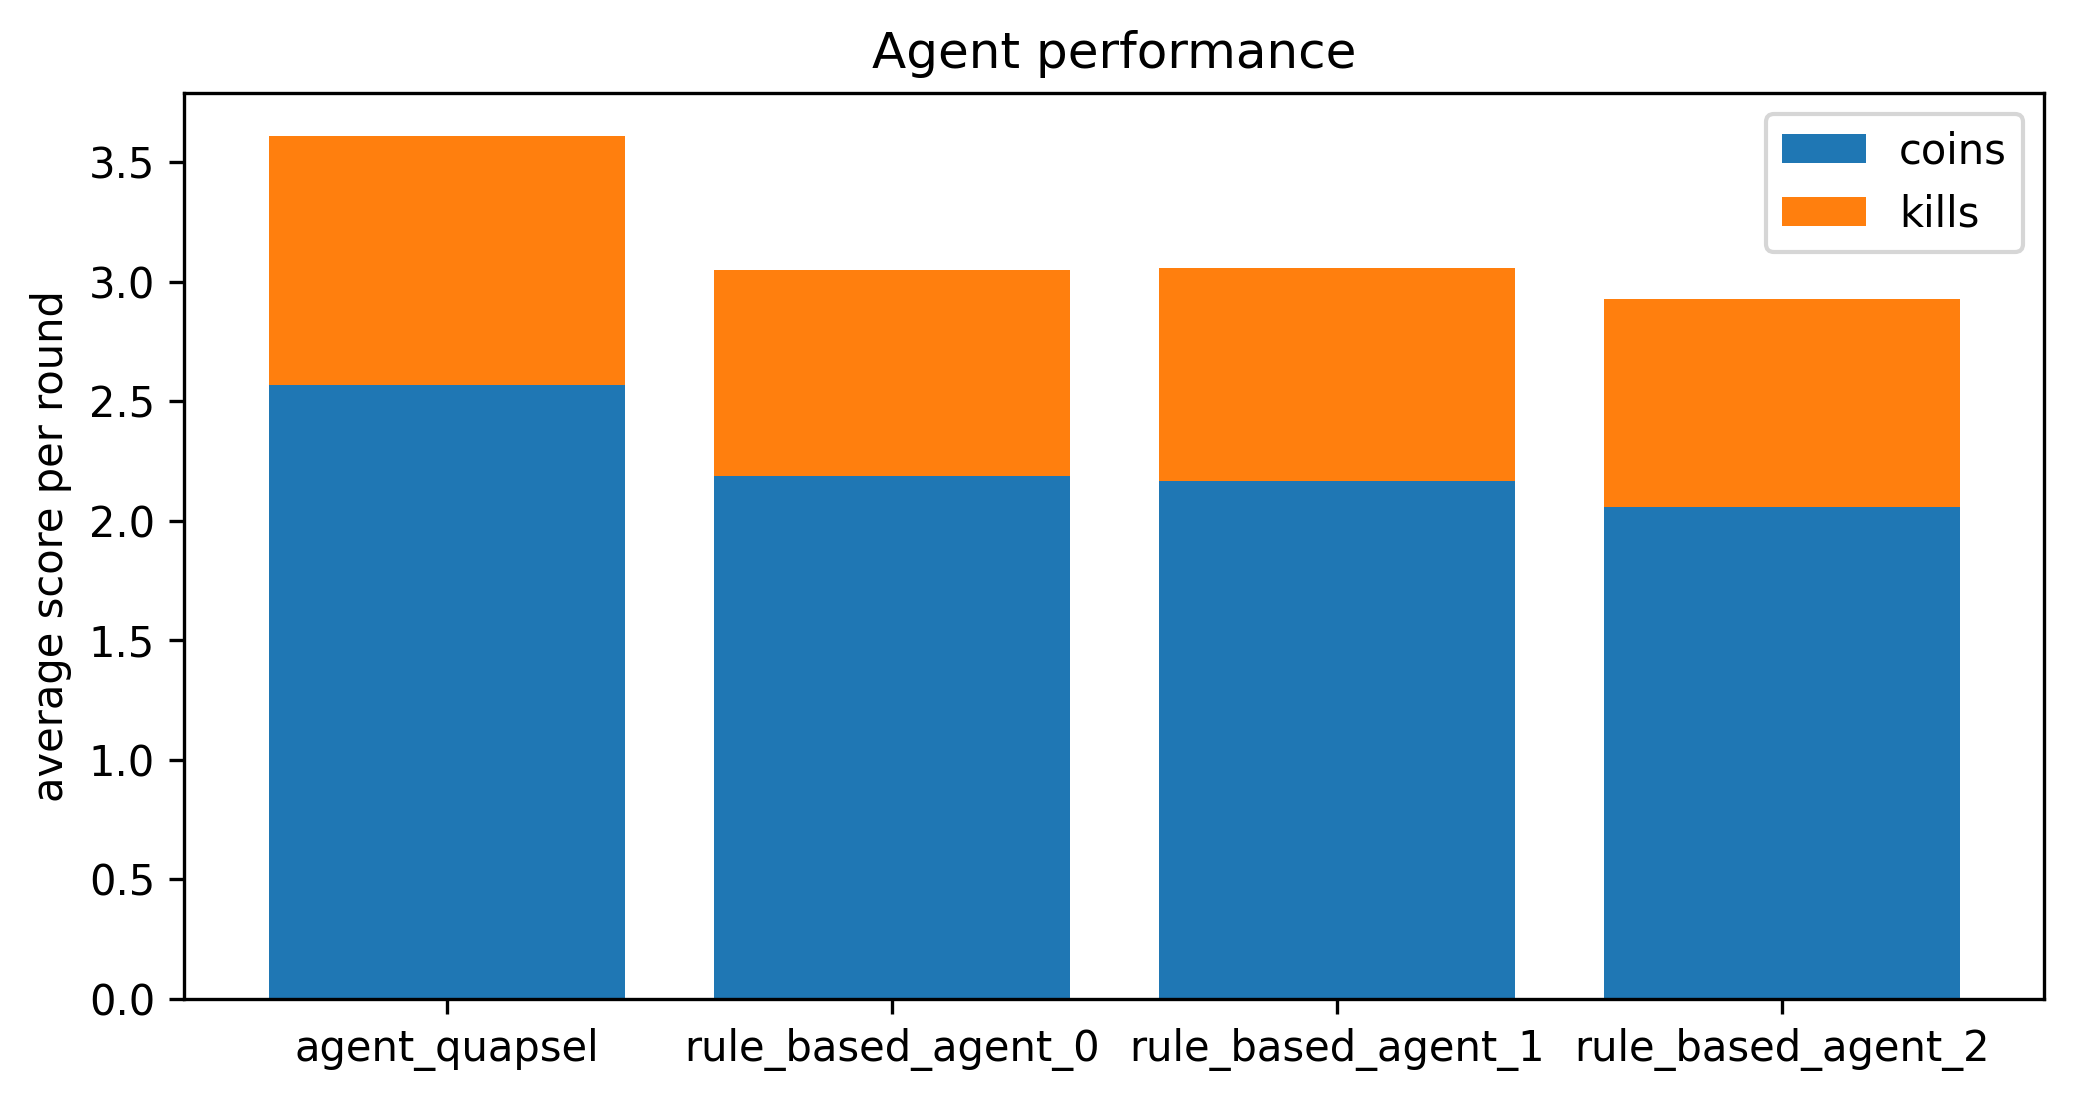

# =============== model-53.pt =============== #


100%|██████████| 500/500 [31:48<00:00,  3.82s/it]


Total agent score: 1780, other agents: [1564, 1536, 1508]
Average score per round: 3.56
Percentage of points achieved: 28.000000000000004%


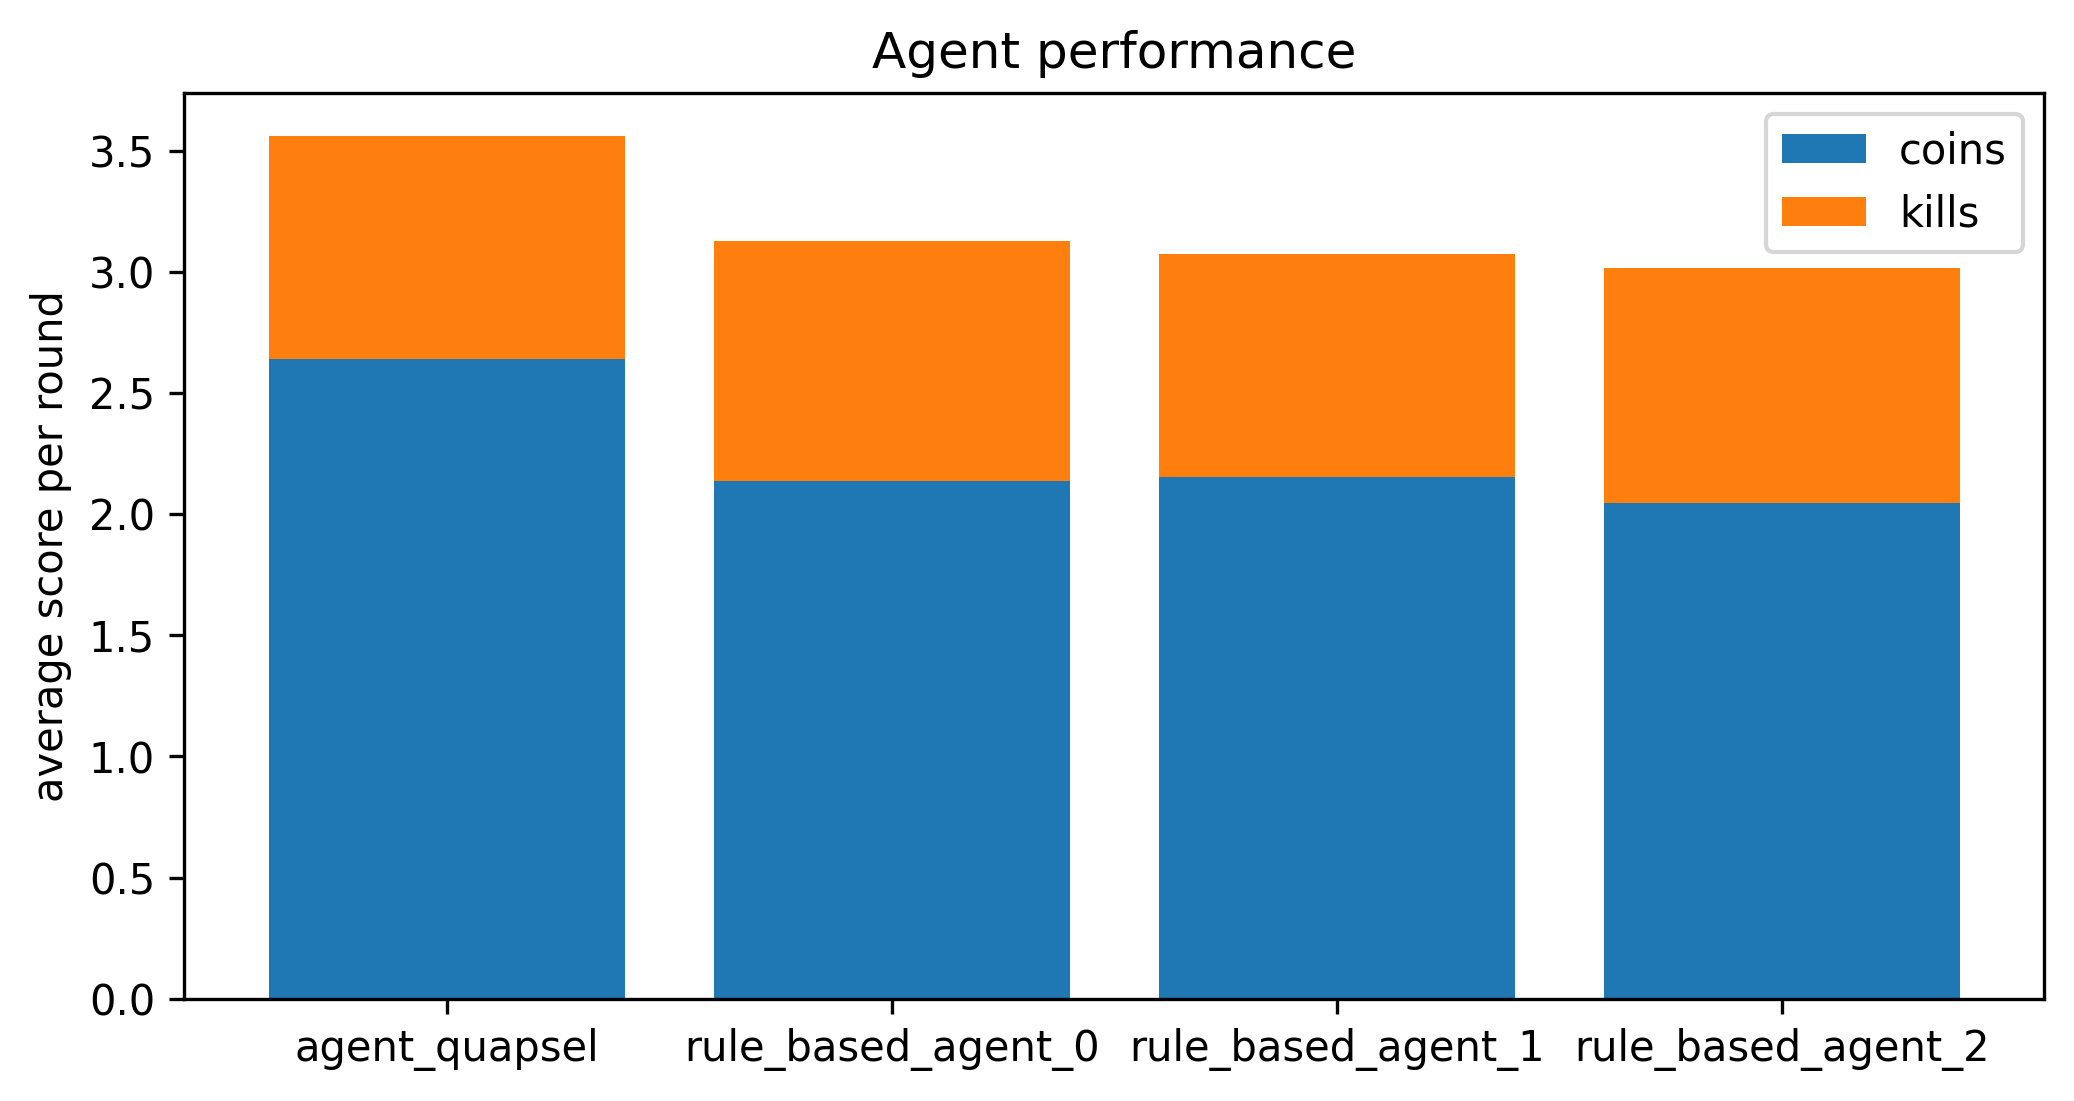

In [3]:
TEST_ROUNDS = 500
models = ['model-76.pt', 'model-54.pt', 'model-53.pt']
for model in models:
    print(f"# =============== {model} =============== #")
    evaluate_performance(model=f"models/{model}", rounds=TEST_ROUNDS)
    plot_performance()

#### Play 1000 test rounds of best three models against each other to determine the best
First time

/home/linus/.local/lib/python3.8/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DummyRegressor from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/linus/.local/lib/python3.8/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/linus/.local/lib/python3.8/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator GradientBoostingRegressor from version 1.0.2 when using version 1.0.1. This might lead to breakin

agent_quapsel: model-76.pt, agent_quapsel1: trained_model.pt, agent_quapsel2: model-54.pt
Total agent score: 2952, other agents: [2645, 3103, 2596]
Average score per round: 2.952
Percentage of points achieved: 26.0%


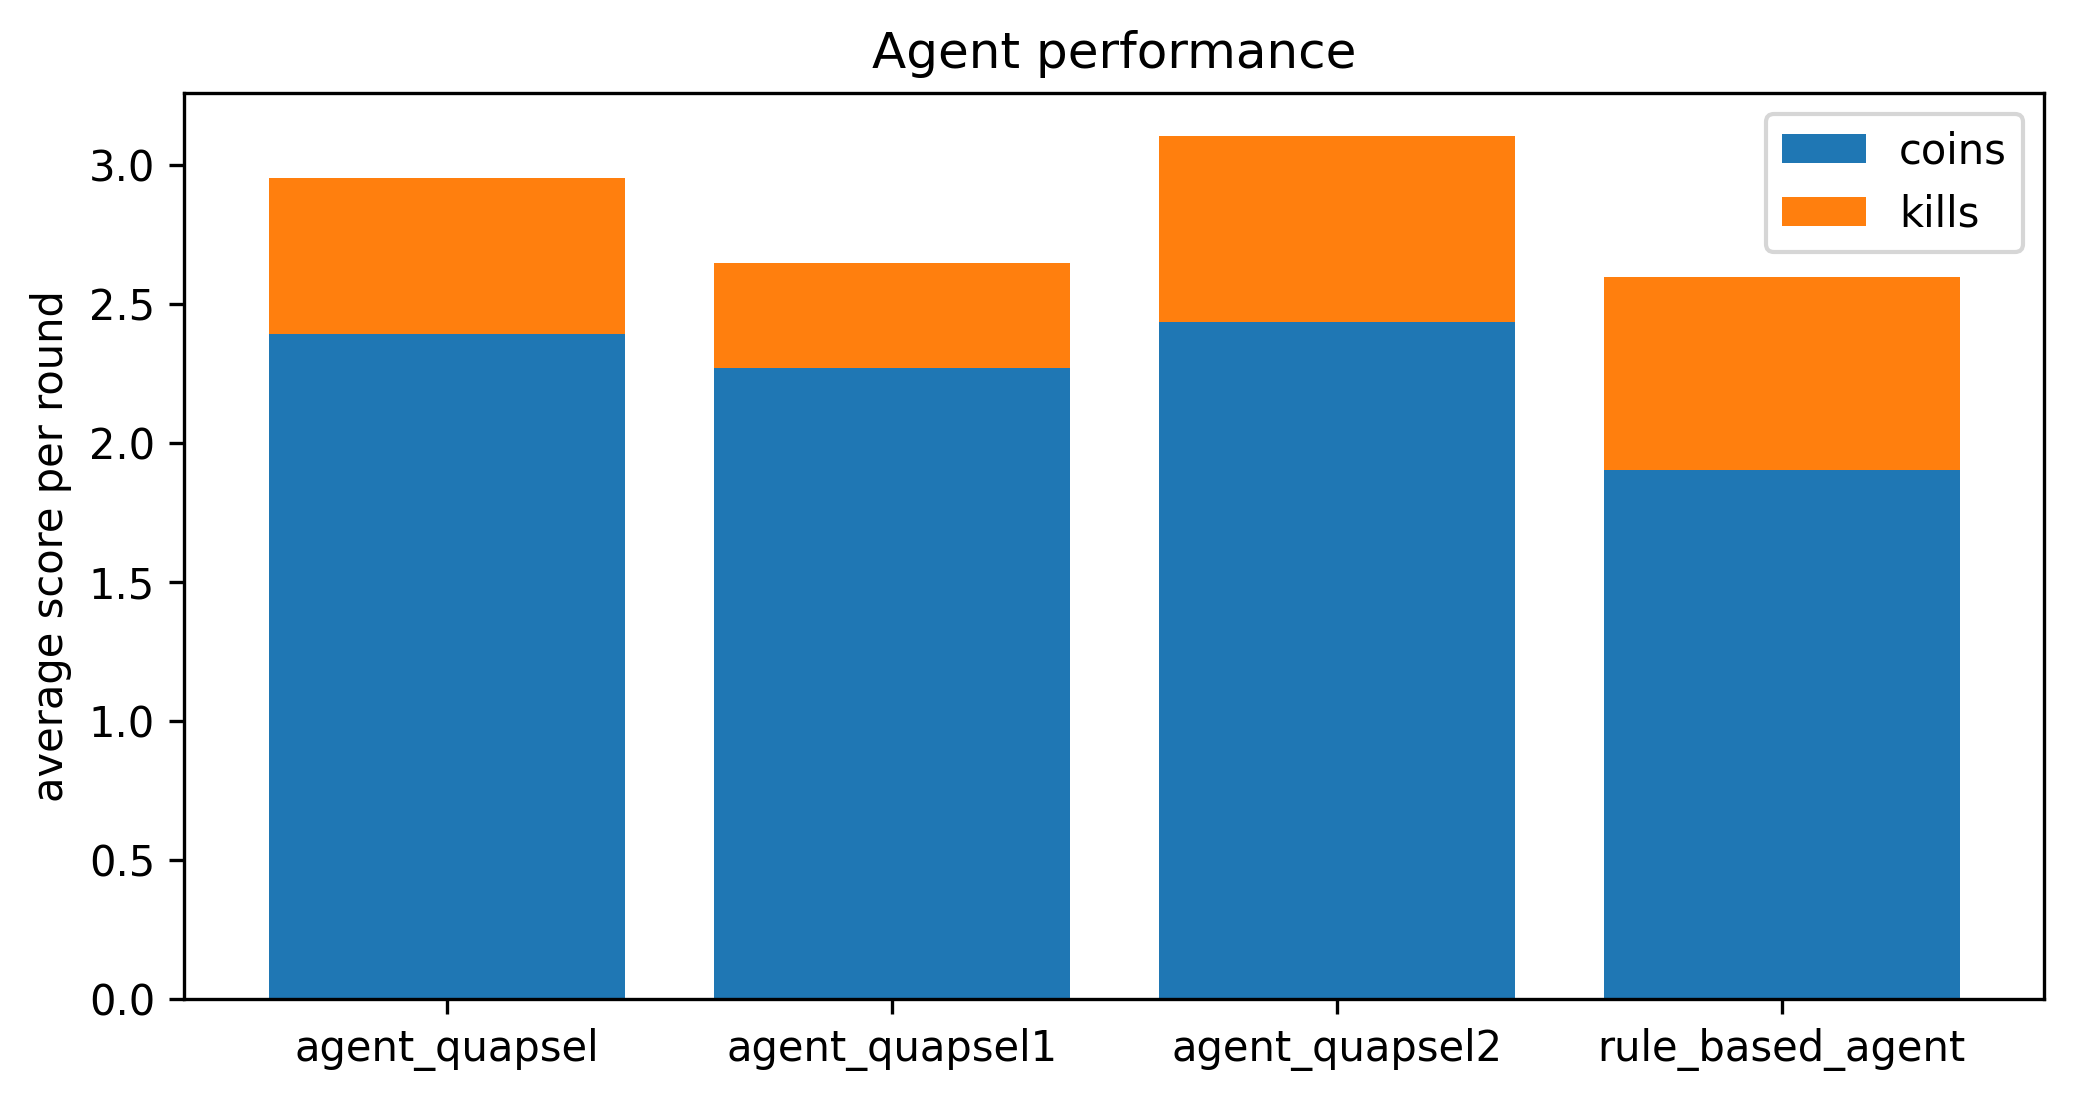

In [7]:
TEST_ROUNDS = 1000
STATSFILE = "stats.json"
if os.path.exists(STATSFILE):
    os.remove(STATSFILE)
os.system(f"python3 ../../main.py play --agents agent_quapsel agent_quapsel1 agent_quapsel2 rule_based_agent --no-gui --n-rounds {TEST_ROUNDS} --save-stats {STATSFILE}")

print(f"agent_quapsel: model-76.pt, agent_quapsel1: trained_model.pt, agent_quapsel2: model-54.pt")
plot_performance()


Run a second time:

/home/linus/.local/lib/python3.8/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DummyRegressor from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/linus/.local/lib/python3.8/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/linus/.local/lib/python3.8/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator GradientBoostingRegressor from version 1.0.2 when using version 1.0.1. This might lead to breakin

agent_quapsel: model-76.pt, agent_quapsel1: trained_model.pt, agent_quapsel2: model-54.pt
Total agent score: 2827, other agents: [2775, 3041, 2759]
Average score per round: 2.827
Percentage of points achieved: 25.0%


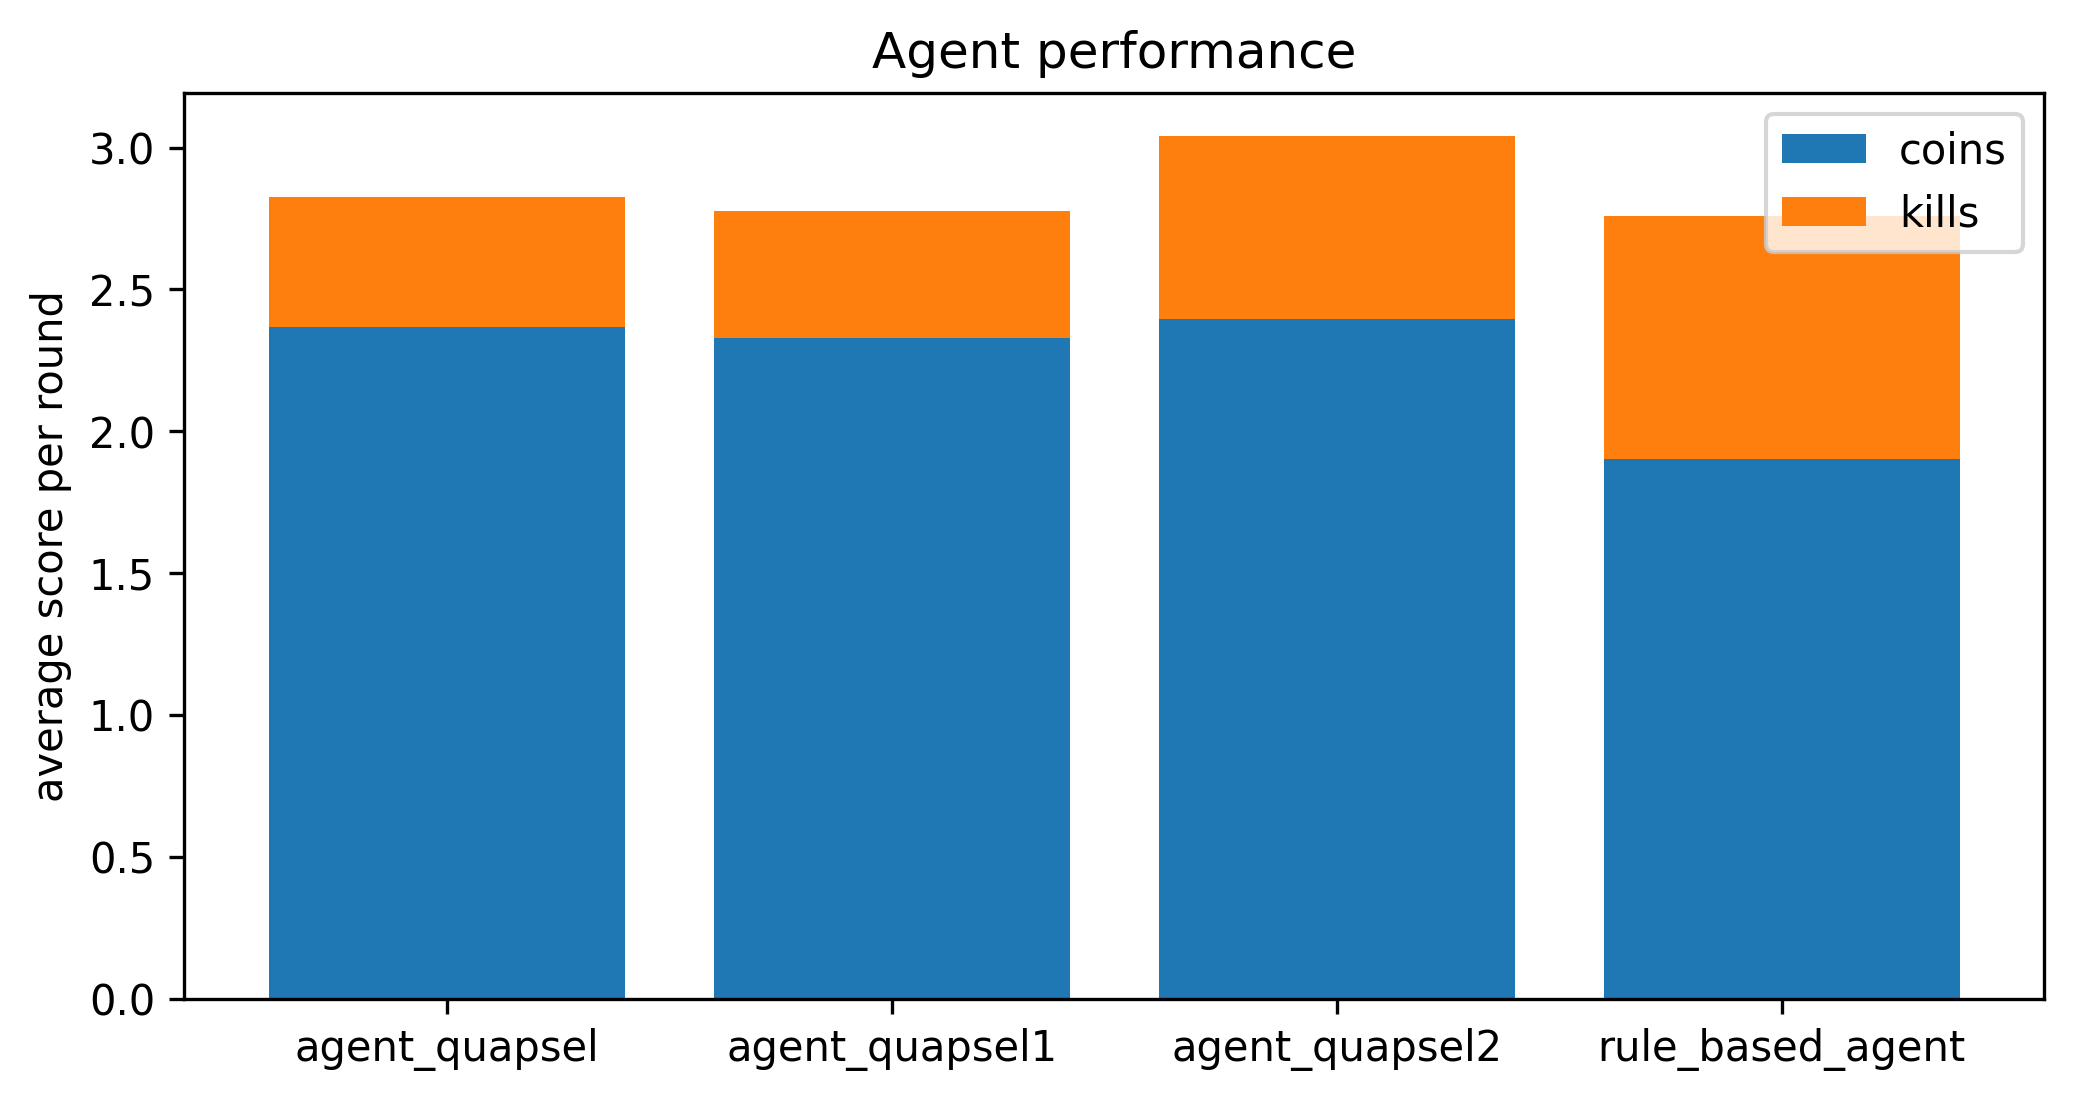

In [8]:
TEST_ROUNDS = 1000
STATSFILE = "stats.json"
if os.path.exists(STATSFILE):
    os.remove(STATSFILE)
os.system(f"python3 ../../main.py play --agents agent_quapsel agent_quapsel1 agent_quapsel2 rule_based_agent --no-gui --n-rounds {TEST_ROUNDS} --save-stats {STATSFILE}")

print(f"agent_quapsel: model-76.pt, agent_quapsel1: trained_model.pt, agent_quapsel2: model-54.pt")
plot_performance()

=> Best performing model for both kills and coins: model-54.pt in agent_quapsel2 